In [80]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import seaborn as sns
from umap import UMAP
import plotly.express as px
import plotly.io as pio
from sklearn.preprocessing import StandardScaler
import scanpy as sc
from tqdm import tqdm

In [2]:
tmfile = '../../Onedrive_IMDEA/Cuervo_lab/Dendra_paper/TM_all_seq2.h5ad'
outputdir = '../../Onedrive_IMDEA/Cuervo_lab/Dendra_paper/Final_figs_v2'
modelmx = '/home/adrianmartin/Onedrive_IMDEA/Scripts/Cuervo_lab/activation_model.xlsx' 

# CMA aging Atlas Summary Figures
In this notebook we will perform summary figures for CMA score and measurements done by IF analysis (CMA activity, % of lysosomes competents for CMA or number of L1 positive lysosomes). The data for the CMA scores UMAPs was downloaded from [Tabula muris senis](https://cellxgene.cziscience.com/collections/0b9d8a04-bb9d-44da-aa27-705bb65b54eb) project, using the **All** files in its *Smart-seq2* version. 

## 1. UMAP Tabula muris + CMA Score

In [3]:
# Import h5ad file in scanpy. 
adata = sc.read_h5ad(tmfile)

In [4]:
# Subsetting only for tissues of interest
adata = adata[adata.obs['tissue'].isin(['pancreas', 'heart', 'brain', 'lung', 'liver', 'kidney'])]

In [5]:
# Normalize as CPM (counts per million)
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e6)

# Transforming CPM into log form
sc.pp.log1p(adata)

/home/adrianmartin/miniconda3/envs/mit/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:523: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[key_n_counts] = counts_per_cell


In [6]:
# Load matrix file with weight and direction 
model_matrix = pd.read_excel(modelmx, 'reordered')

# Removing EEF1A1 and RAC1 genes because they don't appear in the adata
model_matrix = model_matrix.drop([6, 8], axis=0).reset_index()

model_matrix

index           Cat Gene name Gene name Ms  Direction  Weight  \
0       0     Effectors     LAMP2        Lamp2          1       2   
1       1     Effectors     HSPA8        Hspa8          1       1   
2       2     Effectors  HSP90AA1     Hsp90aa1          1       1   
3       3     Effectors  HSP90AB1     Hsp90ab1          1       1   
4       4     Effectors    DNAJB1       Dnajb1          1       1   
5       5       LysoMod      GFAP         Gfap          1       1   
6       7       LysoMod    PHLPP1       Phlpp1          1       1   
7       9  ExtraLysoMod    NFATC1       Nfatc1          1       1   
8      10  ExtraLysoMod     NCOR1        Ncor1          1       1   
9      11  ExtraLysoMod    NFE2L2       Nfe2l2          1       1   
10     12  ExtraLysoMod    RAB11A       Rab11a          1       1   
11     13       LysoMod    RICTOR       Rictor         -1       1   
12     14       LysoMod      AKT1         Akt1         -1       1   
13     15       LysoMod      AKT2         Akt2         -1       1   
14     16       LysoMod      CTSA         Ctsa         -1       1   
15     17  ExtraLysoMod      RARA         Rara         -1       1   

   Uniprot_ID_H Uniprot_ID_Ms   Uniprot_Ms       Ensembl_ID  \
0        P13473        P17047  LAMP2_MOUSE  ENSG00000005893   
1        P11142        P63017  HSP7C_MOUSE  ENSG00000109971   
2        P07900        P07901  HS90A_MOUSE  ENSG00000080824   
3        P08238        P11499  HS90B_MOUSE  ENSG00000096384   
4        P25685        Q9QYJ3  DNJB1_MOUSE  ENSG00000132002   
5        P14136        P03995   GFAP_MOUSE  ENSG00000131095   
6        O60346        Q8CHE4  PHLP1_MOUSE  ENSG00000081913   
7        O95644        O88942  NFAC1_MOUSE  ENSG00000131196   
8        O75376        Q60974  NCOR1_MOUSE  ENSG00000141027   
9        Q16236        Q60795  NF2L2_MOUSE  ENSG00000116044   
10       P62491        P62492  RB11A_MOUSE  ENSG00000103769   
11       Q6R327        Q6QI06  RICTR_MOUSE  ENSG00000164327   
12       P31749        P31750   AKT1_MOUSE  ENSG00000142208   
13       P31749        P31750   AKT1_MOUSE  ENSG00000142208   
14       P10619        P16675   PPGB_MOUSE  ENSG00000064601   
15       P10276        P11416   RARA_MOUSE  ENSG00000131759   

            Ensembl_ms  
0   ENSMUSG00000016534  
1   ENSMUSG00000024359  
2   ENSMUSG00000021270  
3   ENSMUSG00000023944  
4   ENSMUSG00000005483  
5   ENSMUSG00000020932  
6   ENSMUSG00000044340  
7   ENSMUSG00000033016  
8   ENSMUSG00000018501  
9   ENSMUSG00000015839  
10  ENSMUSG00000004771  
11  ENSMUSG00000050310  
12  ENSMUSG00000001729  
13  ENSMUSG00000004056  
14  ENSMUSG00000017760  
15  ENSMUSG00000037992

In [7]:
# Finding CMA network genes in the dataset
cma_network = adata[:, model_matrix["Ensembl_ms"]]

# Calculating the Zs scores
cma_data_zs = cma_network.copy().X.todense().T

for i in tqdm(np.arange(cma_data_zs.shape[0])):
    
    µ = np.mean(cma_data_zs[i, :])
    sd = np.std(cma_data_zs[i, :])
    
    cma_data_zs[i, :] = (cma_data_zs[i, :] - µ)/sd

# Generating a copy of adata.obs to work with
barcode = adata.obs

# New column in barcode (aka adata.obs) with the CMA scores for each cell detected
for i,j in tqdm(enumerate(barcode.index)):
        
    cell_matrix = model_matrix.copy()

    for g in cell_matrix.index:

        cell_matrix.loc[g, 'gene_count'] = cma_data_zs[g, i]

    cell_matrix['gene_score'] = cell_matrix['gene_count'] * cell_matrix['Direction'] * cell_matrix['Weight']
    score = cell_matrix['gene_score'].sum()/np.sum(cell_matrix['Weight'])

    barcode.loc[j, 'score'] = score   

barcode.head()

100%|██████████| 16/16 [00:00<00:00, 3071.34it/s]
43629it [00:45, 965.53it/s]


FACS.selection  age         cell  \
index                                                                    
A10_B000756_B007446_S10.mm10-plus-0-0         Viable  18m  A10_B000756   
A10_B001361_B007505_S10.mm10-plus-0-0         Viable  18m  A10_B001361   
A11_B000756_B007446_S11.mm10-plus-0-0         Viable  18m  A11_B000756   
A11_B001361_B007505_S11.mm10-plus-0-0         Viable  18m  A11_B001361   
A12_B000756_B007446_S12.mm10-plus-0-0         Viable  18m  A12_B000756   

                                         free_annotation method donor_id  \
index                                                                      
A10_B000756_B007446_S10.mm10-plus-0-0  pancreatic B cell   facs  18_45_M   
A10_B001361_B007505_S10.mm10-plus-0-0             B cell   facs  18_46_F   
A11_B000756_B007446_S11.mm10-plus-0-0  pancreatic B cell   facs  18_45_M   
A11_B001361_B007505_S11.mm10-plus-0-0             B cell   facs  18_46_F   
A12_B000756_B007446_S12.mm10-plus-0-0                nan   facs  18_45_M   

                                       subtissue  n_genes     n_counts  \
index                                                                    
A10_B000756_B007446_S10.mm10-plus-0-0  Endocrine     3212  6891.192383   
A10_B001361_B007505_S10.mm10-plus-0-0         RV     1237  3588.732910   
A11_B000756_B007446_S11.mm10-plus-0-0  Endocrine     2544  6017.255371   
A11_B001361_B007505_S11.mm10-plus-0-0         RV     1257  3398.743164   
A12_B000756_B007446_S12.mm10-plus-0-0  Endocrine     3789  4215.626953   

                                      louvain  ...               cell_type  \
index                                          ...                           
A10_B000756_B007446_S10.mm10-plus-0-0      31  ...  type B pancreatic cell   
A10_B001361_B007505_S10.mm10-plus-0-0       1  ...                  B cell   
A11_B000756_B007446_S11.mm10-plus-0-0      31  ...  type B pancreatic cell   
A11_B001361_B007505_S11.mm10-plus-0-0       1  ...                  B cell   
A12_B000756_B007446_S12.mm10-plus-0-0      31  ...  type B pancreatic cell   

                                            assay disease      organism  \
index                                                                     
A10_B000756_B007446_S10.mm10-plus-0-0  Smart-seq2  normal  Mus musculus   
A10_B001361_B007505_S10.mm10-plus-0-0  Smart-seq2  normal  Mus musculus   
A11_B000756_B007446_S11.mm10-plus-0-0  Smart-seq2  normal  Mus musculus   
A11_B001361_B007505_S11.mm10-plus-0-0  Smart-seq2  normal  Mus musculus   
A12_B000756_B007446_S12.mm10-plus-0-0  Smart-seq2  normal  Mus musculus   

                                          sex    tissue  \
index                                                     
A10_B000756_B007446_S10.mm10-plus-0-0    male  pancreas   
A10_B001361_B007505_S10.mm10-plus-0-0  female     heart   
A11_B000756_B007446_S11.mm10-plus-0-0    male  pancreas   
A11_B001361_B007505_S11.mm10-plus-0-0  female     heart   
A12_B000756_B007446_S12.mm10-plus-0-0    male  pancreas   

                                      self_reported_ethnicity  \
index                                                           
A10_B000756_B007446_S10.mm10-plus-0-0                      na   
A10_B001361_B007505_S10.mm10-plus-0-0                      na   
A11_B000756_B007446_S11.mm10-plus-0-0                      na   
A11_B001361_B007505_S11.mm10-plus-0-0                      na   
A12_B000756_B007446_S12.mm10-plus-0-0                      na   

                                        development_stage observation_joinid  \
index                                                                          
A10_B000756_B007446_S10.mm10-plus-0-0  18 month-old stage         K4En@E!h(6   
A10_B001361_B007505_S10.mm10-plus-0-0  18 month-old stage         u9>4eO>X6P   
A11_B000756_B007446_S11.mm10-plus-0-0  18 month-old stage         l~84+$xuu{   
A11_B001361_B007505_S11.mm10-plus-0-0  18 month-old stage         l#3^K>nNvx   
A12_B000756_B007446_S12.mm10-plus-0-0  18 mo

In [8]:
# Generating new ages
for j in tqdm(barcode.index):    
    if barcode.loc[j, 'age'] == '3m':        
        barcode.loc[j, 'new_age'] = 'Young'

    elif barcode.loc[j, 'age'] == '18m':                
        barcode.loc[j, 'new_age'] = 'Old'

    elif barcode.loc[j, 'age'] == '24m': 
        barcode.loc[j, 'new_age'] = 'Old'
barcode.head()

100%|██████████| 43629/43629 [00:02<00:00, 18533.04it/s]


FACS.selection  age         cell  \
index                                                                    
A10_B000756_B007446_S10.mm10-plus-0-0         Viable  18m  A10_B000756   
A10_B001361_B007505_S10.mm10-plus-0-0         Viable  18m  A10_B001361   
A11_B000756_B007446_S11.mm10-plus-0-0         Viable  18m  A11_B000756   
A11_B001361_B007505_S11.mm10-plus-0-0         Viable  18m  A11_B001361   
A12_B000756_B007446_S12.mm10-plus-0-0         Viable  18m  A12_B000756   

                                         free_annotation method donor_id  \
index                                                                      
A10_B000756_B007446_S10.mm10-plus-0-0  pancreatic B cell   facs  18_45_M   
A10_B001361_B007505_S10.mm10-plus-0-0             B cell   facs  18_46_F   
A11_B000756_B007446_S11.mm10-plus-0-0  pancreatic B cell   facs  18_45_M   
A11_B001361_B007505_S11.mm10-plus-0-0             B cell   facs  18_46_F   
A12_B000756_B007446_S12.mm10-plus-0-0                nan   facs  18_45_M   

                                       subtissue  n_genes     n_counts  \
index                                                                    
A10_B000756_B007446_S10.mm10-plus-0-0  Endocrine     3212  6891.192383   
A10_B001361_B007505_S10.mm10-plus-0-0         RV     1237  3588.732910   
A11_B000756_B007446_S11.mm10-plus-0-0  Endocrine     2544  6017.255371   
A11_B001361_B007505_S11.mm10-plus-0-0         RV     1257  3398.743164   
A12_B000756_B007446_S12.mm10-plus-0-0  Endocrine     3789  4215.626953   

                                      louvain  ...       assay disease  \
index                                          ...                       
A10_B000756_B007446_S10.mm10-plus-0-0      31  ...  Smart-seq2  normal   
A10_B001361_B007505_S10.mm10-plus-0-0       1  ...  Smart-seq2  normal   
A11_B000756_B007446_S11.mm10-plus-0-0      31  ...  Smart-seq2  normal   
A11_B001361_B007505_S11.mm10-plus-0-0       1  ...  Smart-seq2  normal   
A12_B000756_B007446_S12.mm10-plus-0-0      31  ...  Smart-seq2  normal   

                                           organism     sex    tissue  \
index                                                                   
A10_B000756_B007446_S10.mm10-plus-0-0  Mus musculus    male  pancreas   
A10_B001361_B007505_S10.mm10-plus-0-0  Mus musculus  female     heart   
A11_B000756_B007446_S11.mm10-plus-0-0  Mus musculus    male  pancreas   
A11_B001361_B007505_S11.mm10-plus-0-0  Mus musculus  female     heart   
A12_B000756_B007446_S12.mm10-plus-0-0  Mus musculus    male  pancreas   

                                      self_reported_ethnicity  \
index                                                           
A10_B000756_B007446_S10.mm10-plus-0-0                      na   
A10_B001361_B007505_S10.mm10-plus-0-0                      na   
A11_B000756_B007446_S11.mm10-plus-0-0                      na   
A11_B001361_B007505_S11.mm10-plus-0-0                      na   
A12_B000756_B007446_S12.mm10-plus-0-0                      na   

                                        development_stage observation_joinid  \
index                                                                          
A10_B000756_B007446_S10.mm10-plus-0-0  18 month-old stage         K4En@E!h(6   
A10_B001361_B007505_S10.mm10-plus-0-0  18 month-old stage         u9>4eO>X6P   
A11_B000756_B007446_S11.mm10-plus-0-0  18 month-old stage         l~84+$xuu{   
A11_B001361_B007505_S11.mm10-plus-0-0  18 month-old stage         l#3^K>nNvx   
A12_B000756_B007446_S12.mm10-plus-0-0  18 month-old stage         6Y}n#KG|Bw   

                                          score  new_age  
index                                                     
A10_B000756_B007446_S10.mm10-plus-0-0 -0.132721      Old  
A10_B001361_B007505_S10.mm10-plus-0-0  0.072865      Old  
A11_B000756_B007446_S11.mm10-plus-0-0  0.016736      Old  
A11_B001361_B007505_S11.mm10-plus-0-0  0.199450      Old  
A12_B000756_B007446_S12.mm10-plus-0-0  0.213472      Old  

[5 ro

In [9]:
# Calculation of net score to 3m using whole tissue CMA score mean
µ = np.mean(barcode[barcode['new_age'] == 'Young']['score'])

for i in tqdm(barcode.index):
    barcode.loc[i, 'net_score'] = barcode.loc[i, 'score'] - µ 

barcode.head()

100%|██████████| 43629/43629 [00:02<00:00, 20063.41it/s]


FACS.selection  age         cell  \
index                                                                    
A10_B000756_B007446_S10.mm10-plus-0-0         Viable  18m  A10_B000756   
A10_B001361_B007505_S10.mm10-plus-0-0         Viable  18m  A10_B001361   
A11_B000756_B007446_S11.mm10-plus-0-0         Viable  18m  A11_B000756   
A11_B001361_B007505_S11.mm10-plus-0-0         Viable  18m  A11_B001361   
A12_B000756_B007446_S12.mm10-plus-0-0         Viable  18m  A12_B000756   

                                         free_annotation method donor_id  \
index                                                                      
A10_B000756_B007446_S10.mm10-plus-0-0  pancreatic B cell   facs  18_45_M   
A10_B001361_B007505_S10.mm10-plus-0-0             B cell   facs  18_46_F   
A11_B000756_B007446_S11.mm10-plus-0-0  pancreatic B cell   facs  18_45_M   
A11_B001361_B007505_S11.mm10-plus-0-0             B cell   facs  18_46_F   
A12_B000756_B007446_S12.mm10-plus-0-0                nan   facs  18_45_M   

                                       subtissue  n_genes     n_counts  \
index                                                                    
A10_B000756_B007446_S10.mm10-plus-0-0  Endocrine     3212  6891.192383   
A10_B001361_B007505_S10.mm10-plus-0-0         RV     1237  3588.732910   
A11_B000756_B007446_S11.mm10-plus-0-0  Endocrine     2544  6017.255371   
A11_B001361_B007505_S11.mm10-plus-0-0         RV     1257  3398.743164   
A12_B000756_B007446_S12.mm10-plus-0-0  Endocrine     3789  4215.626953   

                                      louvain  ... disease      organism  \
index                                          ...                         
A10_B000756_B007446_S10.mm10-plus-0-0      31  ...  normal  Mus musculus   
A10_B001361_B007505_S10.mm10-plus-0-0       1  ...  normal  Mus musculus   
A11_B000756_B007446_S11.mm10-plus-0-0      31  ...  normal  Mus musculus   
A11_B001361_B007505_S11.mm10-plus-0-0       1  ...  normal  Mus musculus   
A12_B000756_B007446_S12.mm10-plus-0-0      31  ...  normal  Mus musculus   

                                          sex    tissue  \
index                                                     
A10_B000756_B007446_S10.mm10-plus-0-0    male  pancreas   
A10_B001361_B007505_S10.mm10-plus-0-0  female     heart   
A11_B000756_B007446_S11.mm10-plus-0-0    male  pancreas   
A11_B001361_B007505_S11.mm10-plus-0-0  female     heart   
A12_B000756_B007446_S12.mm10-plus-0-0    male  pancreas   

                                      self_reported_ethnicity  \
index                                                           
A10_B000756_B007446_S10.mm10-plus-0-0                      na   
A10_B001361_B007505_S10.mm10-plus-0-0                      na   
A11_B000756_B007446_S11.mm10-plus-0-0                      na   
A11_B001361_B007505_S11.mm10-plus-0-0                      na   
A12_B000756_B007446_S12.mm10-plus-0-0                      na   

                                        development_stage observation_joinid  \
index                                                                          
A10_B000756_B007446_S10.mm10-plus-0-0  18 month-old stage         K4En@E!h(6   
A10_B001361_B007505_S10.mm10-plus-0-0  18 month-old stage         u9>4eO>X6P   
A11_B000756_B007446_S11.mm10-plus-0-0  18 month-old stage         l~84+$xuu{   
A11_B001361_B007505_S11.mm10-plus-0-0  18 month-old stage         l#3^K>nNvx   
A12_B000756_B007446_S12.mm10-plus-0-0  18 month-old stage         6Y}n#KG|Bw   

                                          score new_age  net_score  
index                                                               
A10_B000756_B007446_S10.mm10-plus-0-0 -0.132721     Old  -0.187852  
A10_B001361_B007505_S10.mm10-plus-0-0  0.072865     Old   0.017734  
A11_B000756_B007446_S11.mm10-plus-0-0  0.016736     Old  -0.038396  
A11_B001361_B007505_S11.mm10-plus-0-0  0.199450     Old   0.144319  
A12_B000756_B007446_S12.mm10-plus-0-0  0.213472     Old   0.158340  

[5 rows x 35 column

In [10]:
# Calculation of net score to 3m by tissue
for maj_cell in tqdm(np.unique(barcode['tissue'])):
    
    µ = np.mean(barcode[barcode['tissue'] == maj_cell][barcode['new_age'] == 'Young']['score'])
    
    for cell_index in barcode[barcode['tissue'] == maj_cell].index:
    
        barcode.loc[cell_index, 'net_score_tissue'] = barcode.loc[cell_index, 'score'] - µ  

barcode.head()

  0%|          | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_15489/4131233559.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  µ = np.mean(barcode[barcode['tissue'] == maj_cell][barcode['new_age'] == 'Young']['score'])
 17%|█▋        | 1/6 [00:00<00:04,  1.04it/s]/tmp/ipykernel_15489/4131233559.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  µ = np.mean(barcode[barcode['tissue'] == maj_cell][barcode['new_age'] == 'Young']['score'])
 33%|███▎      | 2/6 [00:01<00:02,  1.51it/s]/tmp/ipykernel_15489/4131233559.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  µ = np.mean(barcode[barcode['tissue'] == maj_cell][barcode['new_age'] == 'Young']['score'])
/tmp/ipykernel_15489/4131233559.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  µ = np.mean(barcode[barcode['tissue'] == maj_cell][barcode['new_age'] == 'Young']['score'])
 67%|██████▋   | 4/6 [00:01<00:00,  3.14i

FACS.selection  age         cell  \
index                                                                    
A10_B000756_B007446_S10.mm10-plus-0-0         Viable  18m  A10_B000756   
A10_B001361_B007505_S10.mm10-plus-0-0         Viable  18m  A10_B001361   
A11_B000756_B007446_S11.mm10-plus-0-0         Viable  18m  A11_B000756   
A11_B001361_B007505_S11.mm10-plus-0-0         Viable  18m  A11_B001361   
A12_B000756_B007446_S12.mm10-plus-0-0         Viable  18m  A12_B000756   

                                         free_annotation method donor_id  \
index                                                                      
A10_B000756_B007446_S10.mm10-plus-0-0  pancreatic B cell   facs  18_45_M   
A10_B001361_B007505_S10.mm10-plus-0-0             B cell   facs  18_46_F   
A11_B000756_B007446_S11.mm10-plus-0-0  pancreatic B cell   facs  18_45_M   
A11_B001361_B007505_S11.mm10-plus-0-0             B cell   facs  18_46_F   
A12_B000756_B007446_S12.mm10-plus-0-0                nan   facs  18_45_M   

                                       subtissue  n_genes     n_counts  \
index                                                                    
A10_B000756_B007446_S10.mm10-plus-0-0  Endocrine     3212  6891.192383   
A10_B001361_B007505_S10.mm10-plus-0-0         RV     1237  3588.732910   
A11_B000756_B007446_S11.mm10-plus-0-0  Endocrine     2544  6017.255371   
A11_B001361_B007505_S11.mm10-plus-0-0         RV     1257  3398.743164   
A12_B000756_B007446_S12.mm10-plus-0-0  Endocrine     3789  4215.626953   

                                      louvain  ...      organism     sex  \
index                                          ...                         
A10_B000756_B007446_S10.mm10-plus-0-0      31  ...  Mus musculus    male   
A10_B001361_B007505_S10.mm10-plus-0-0       1  ...  Mus musculus  female   
A11_B000756_B007446_S11.mm10-plus-0-0      31  ...  Mus musculus    male   
A11_B001361_B007505_S11.mm10-plus-0-0       1  ...  Mus musculus  female   
A12_B000756_B007446_S12.mm10-plus-0-0      31  ...  Mus musculus    male   

                                         tissue self_reported_ethnicity  \
index                                                                     
A10_B000756_B007446_S10.mm10-plus-0-0  pancreas                      na   
A10_B001361_B007505_S10.mm10-plus-0-0     heart                      na   
A11_B000756_B007446_S11.mm10-plus-0-0  pancreas                      na   
A11_B001361_B007505_S11.mm10-plus-0-0     heart                      na   
A12_B000756_B007446_S12.mm10-plus-0-0  pancreas                      na   

                                        development_stage observation_joinid  \
index                                                                          
A10_B000756_B007446_S10.mm10-plus-0-0  18 month-old stage         K4En@E!h(6   
A10_B001361_B007505_S10.mm10-plus-0-0  18 month-old stage         u9>4eO>X6P   
A11_B000756_B007446_S11.mm10-plus-0-0  18 month-old stage         l~84+$xuu{   
A11_B001361_B007505_S11.mm10-plus-0-0  18 month-old stage         l#3^K>nNvx   
A12_B000756_B007446_S12.mm10-plus-0-0  18 month-old stage         6Y}n#KG|Bw   

                                          score new_age net_score  \
index                                                               
A10_B000756_B007446_S10.mm10-plus-0-0 -0.132721     Old -0.187852   
A10_B001361_B007505_S10.mm10-plus-0-0  0.072865     Old  0.017734   
A11_B000756_B007446_S11.mm10-plus-0-0  0.016736     Old -0.038396   
A11_B001361_B007505_S11.mm10-plus-0-0  0.199450     Old  0.144319   
A12_B000756_B007446_S12.mm10-plus-0-0  0.213472     Old  0.158340   

                                       net_score_tissue  
index                                                    
A10_B000756_B007446_S10.mm10-plus-0-0         -0.207802  
A10_B001361_B007505_S10.mm10-plus-0-0          0.031926  
A11_B000756_B007446_S11.mm10-plus-0-0         -0.058346  
A11_B001361_B007505_S11.mm10-plus-0-0          0.158511  
A12_B000756_B00

In [11]:
adata.obs['tissue'] = adata.obs['tissue'].str.capitalize() #Capitalizing tissue names

#Giving order to tissues in adata.obs (aka barcode)
tejidos=['Brain', 'Heart', 'Kidney', 'Liver', 'Lung', 'Pancreas']

adata.obs['tissue']=pd.Categorical(
    values=adata.obs.tissue, categories=tejidos, ordered=True)

In [31]:
pal = sns.color_palette('Dark2')
pal.append('#e41a1c')
pal


[(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
 (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
 (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
 (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
 (0.4, 0.6509803921568628, 0.11764705882352941),
 (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
 (0.6509803921568628, 0.4627450980392157, 0.11372549019607843),
 (0.4, 0.4, 0.4),
 '#e41a1c']

/home/adrianmartin/miniconda3/envs/mit/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


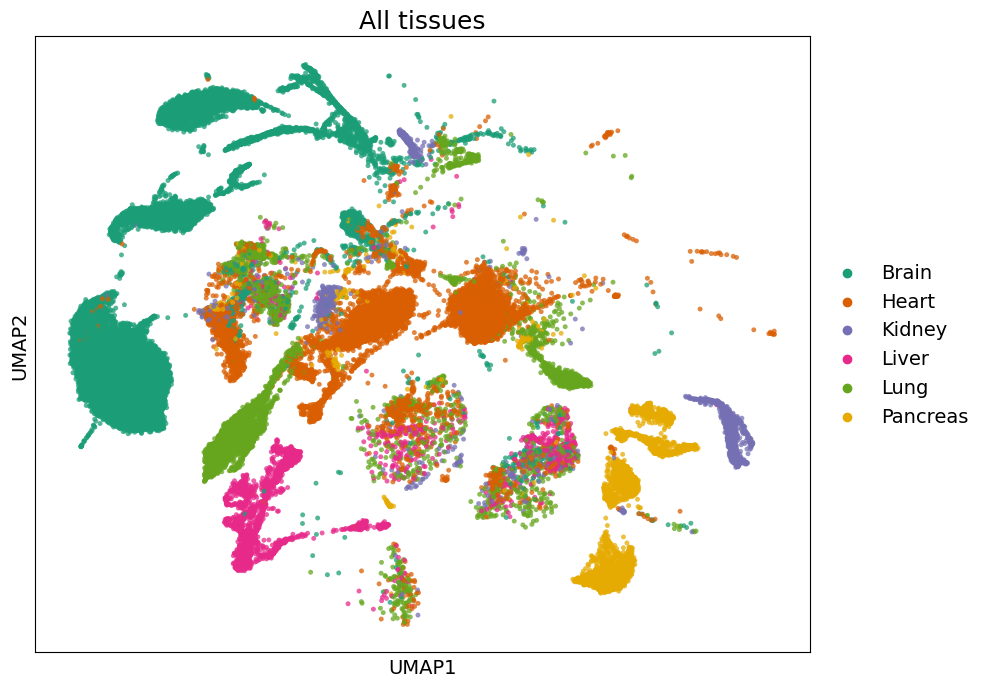

In [15]:
# UMAP for tissues
with plt.rc_context({"figure.figsize": (10, 8), "axes.labelsize":(14), "axes.titlesize":(18)}):
    sc.pl.umap(adata, color=['tissue'], palette=pal, legend_fontsize=14, title='All tissues', size=50, alpha=0.75, show=False)
    plt.savefig(outputdir+'/AT_umap.png',bbox_inches='tight', dpi=600)
    plt.show()

/tmp/ipykernel_15489/3221265912.py:12: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  fig.colorbar(sm, shrink=.5)


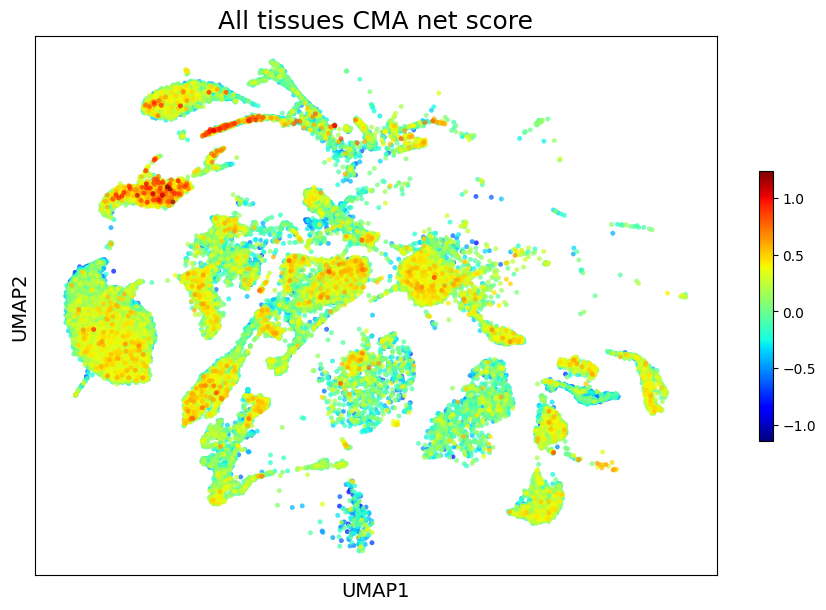

In [17]:
# UMAP for CMA net score per tissue
with plt.rc_context({"figure.figsize": (11, 7), "axes.labelsize":(14), "axes.titlesize":(18)}):
    sc.pl.umap(adata, color=['net_score_tissue'], cmap='jet',
               title='All tissues CMA net score', 
               legend_fontsize=14, size=50, alpha=0.75, show=False, colorbar_loc=None)
    
    fig = plt.gcf()
    norm = plt.Normalize(np.min(adata.obs['net_score_tissue']), 
                         np.max(adata.obs['net_score_tissue']))
    sm = plt.cm.ScalarMappable(cmap="jet", norm=norm)
    sm.set_array([])
    fig.colorbar(sm, shrink=.5)
    
# Plot the colorbar
    plt.savefig(outputdir+'/AT_umap_ptnscore.png',bbox_inches='tight', dpi=600)
    plt.show()

/home/adrianmartin/miniconda3/envs/mit/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


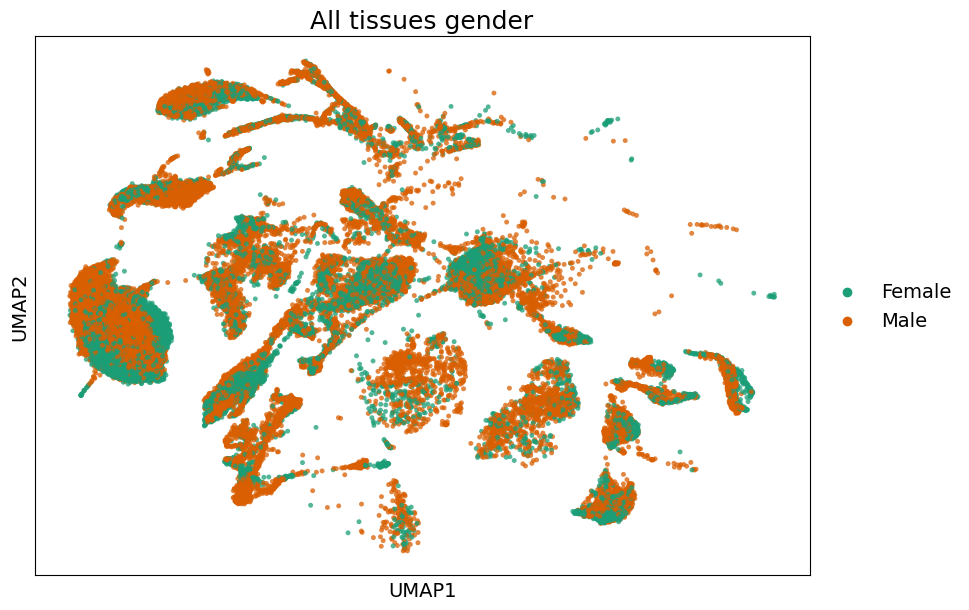

In [23]:
#UMAP for gender
adata.obs['sex'] = adata.obs['sex'].str.capitalize()
with plt.rc_context({"figure.figsize": (10, 7), "axes.labelsize":(14), "axes.titlesize":(18)}):
    sc.pl.umap(adata, color=['sex'], palette=pal, title= 'All tissues gender', size=50, alpha=0.75, legend_fontsize=14, show=False)
    plt.savefig(outputdir+'/AT_umap_sex.png',bbox_inches='tight', dpi=600)
    plt.show()

/home/adrianmartin/miniconda3/envs/mit/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


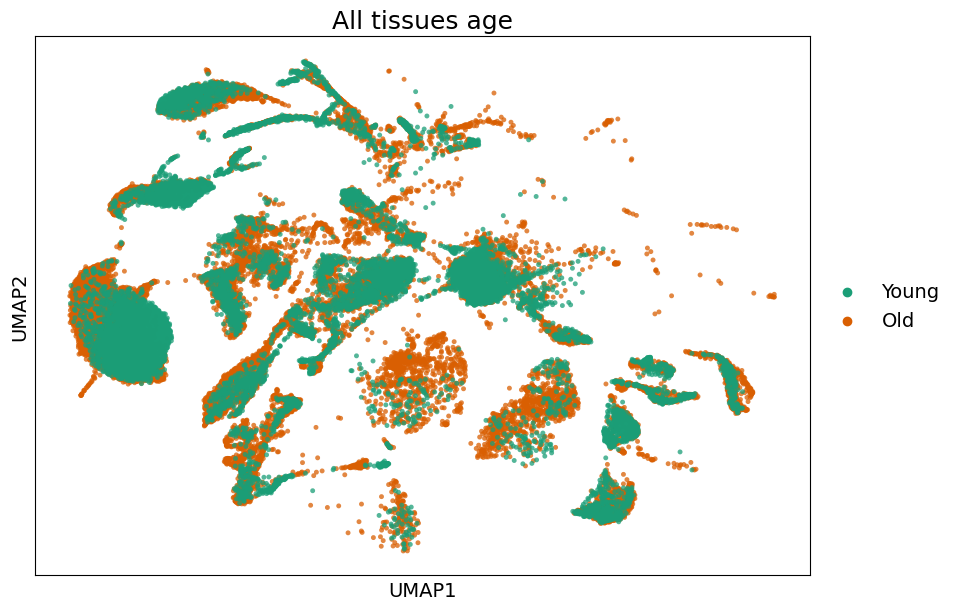

In [24]:
#UMAP for age
adata.obs['new_age']=pd.Categorical(values=adata.obs.new_age, categories=['Young', 'Old'], ordered=True)
with plt.rc_context({"figure.figsize": (10, 7), "axes.labelsize":(14), "axes.titlesize":(18)}):
    sc.pl.umap(adata, color=['new_age'], palette=pal, title= 'All tissues age', size=50, alpha=0.75, legend_fontsize=14, show=False)
    plt.savefig(outputdir+'/AT_umap_age.png',bbox_inches='tight', dpi=600)
    plt.show()

/home/adrianmartin/miniconda3/envs/mit/lib/python3.10/site-packages/scanpy/plotting/_utils.py:431: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/home/adrianmartin/miniconda3/envs/mit/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


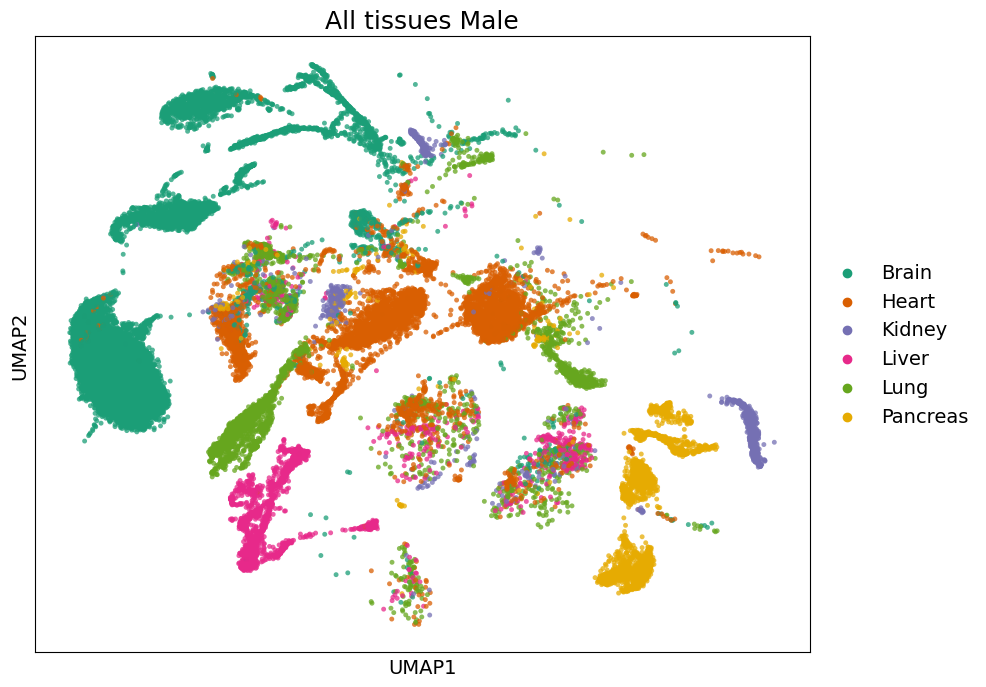

/home/adrianmartin/miniconda3/envs/mit/lib/python3.10/site-packages/scanpy/plotting/_utils.py:431: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/home/adrianmartin/miniconda3/envs/mit/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


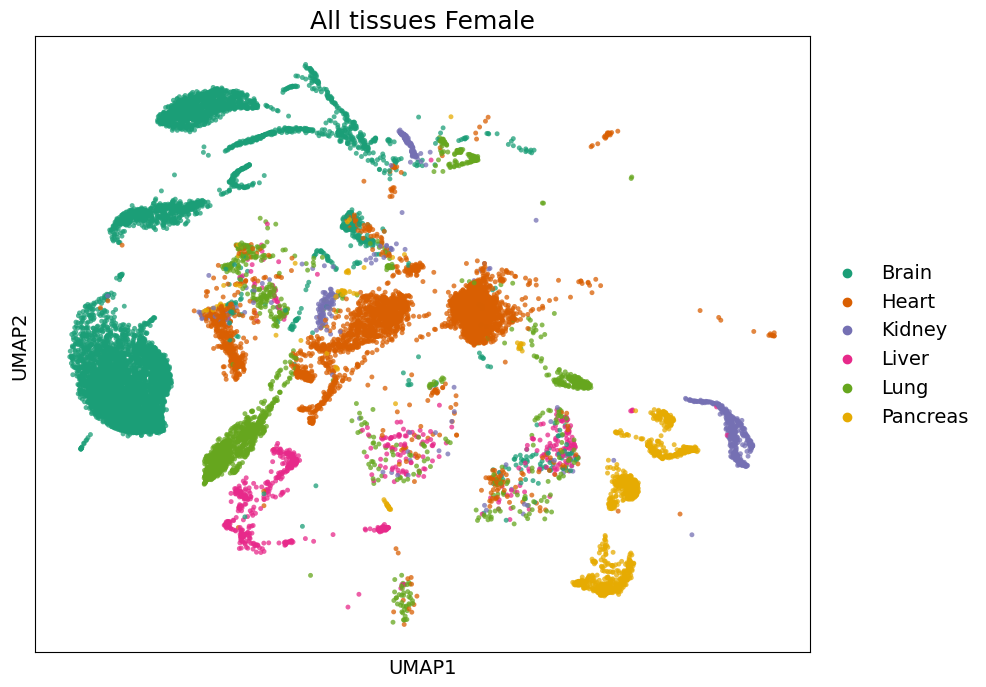

In [25]:
#UMAP for tissues by gender
for i in barcode.sex.unique():
    # UMAP for tissues
    with plt.rc_context({"figure.figsize": (10, 8), "axes.labelsize":(14), "axes.titlesize":(18)}):
        sc.pl.umap(adata[(adata.obs['sex']==i)], 
                   color=['tissue'], palette=pal, size=50, alpha=0.75, legend_fontsize=14, 
                   title='All tissues ' + i, show=False)
        if i == 'Female':
            plt.savefig(outputdir+'/AT_umap_'+'f.png',bbox_inches='tight', 
                        dpi=600)
        else:
            plt.savefig(outputdir+'/AT_umap_'+'m.png',bbox_inches='tight', 
                        dpi=600)
        plt.show()
    

/tmp/ipykernel_15489/1467117845.py:16: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  fig.colorbar(sm, shrink=.5)


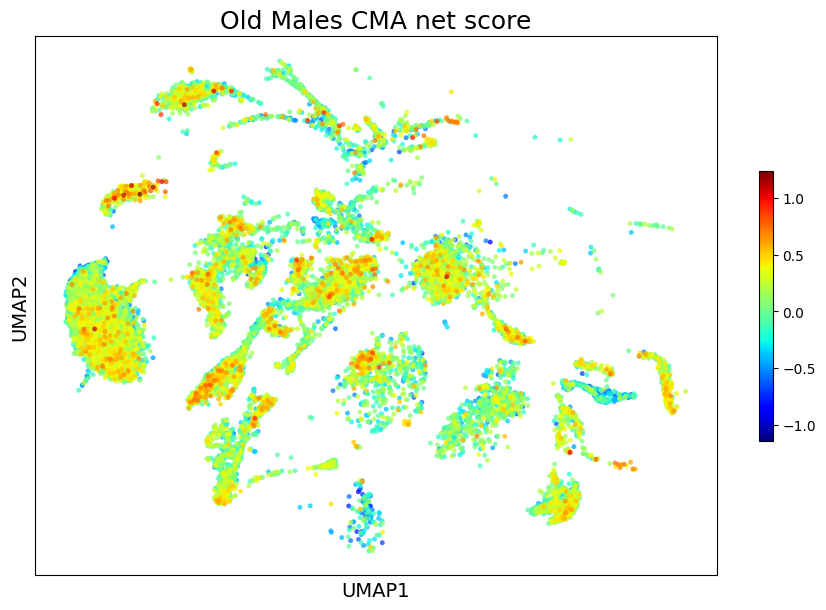

/tmp/ipykernel_15489/1467117845.py:16: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  fig.colorbar(sm, shrink=.5)


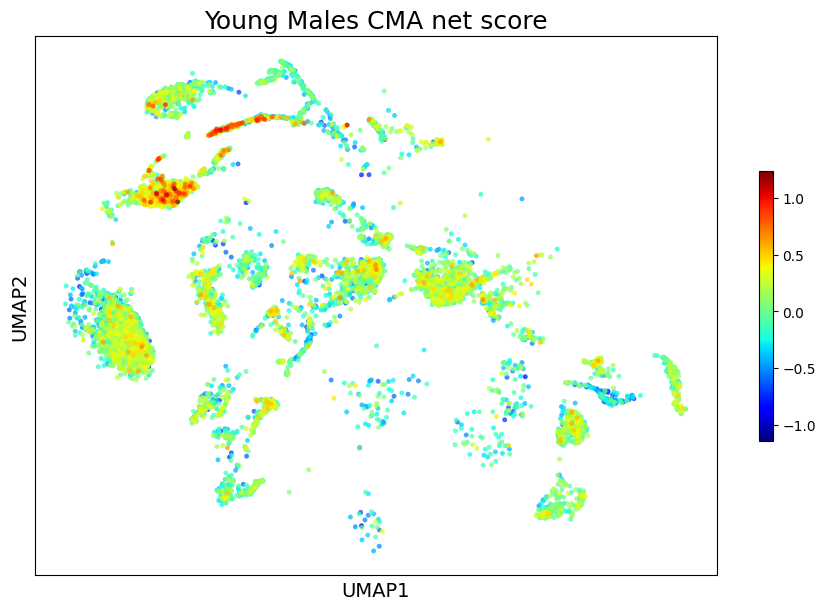

/tmp/ipykernel_15489/1467117845.py:16: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  fig.colorbar(sm, shrink=.5)


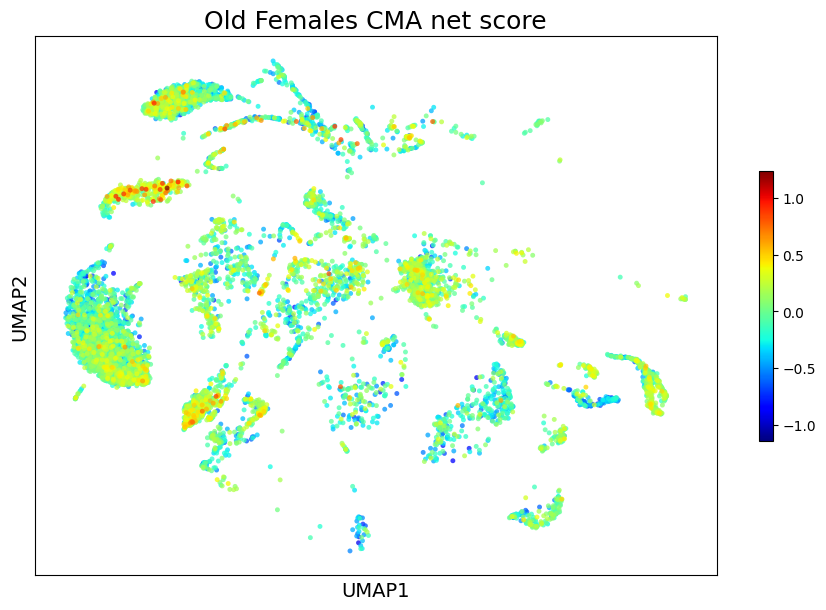

/tmp/ipykernel_15489/1467117845.py:16: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  fig.colorbar(sm, shrink=.5)


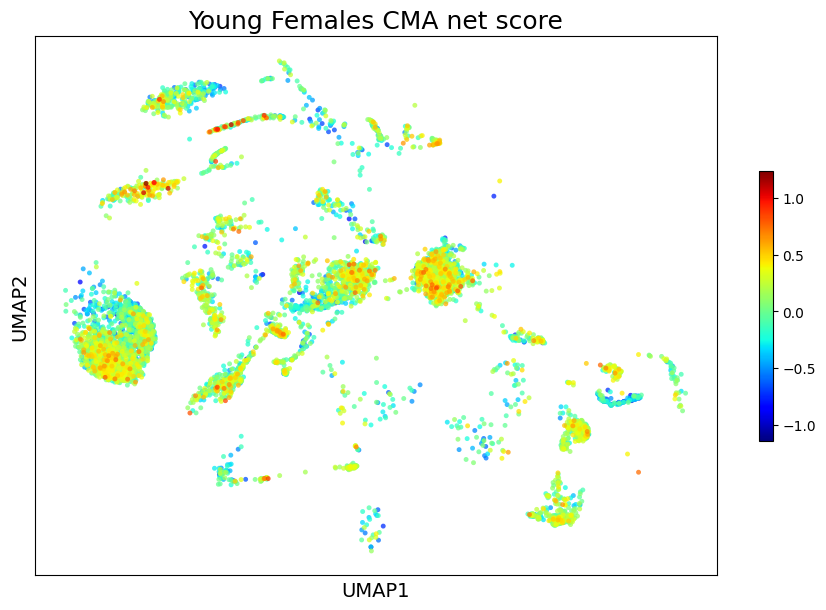

In [54]:
#UMAP for CMA net score per tissue by gender and age
for i in barcode.sex.unique():
    for j in barcode.new_age.unique():
        # UMAP for CMA net score per tissue
        with plt.rc_context({"figure.figsize": (11, 7), "axes.labelsize":(14), "axes.titlesize":(18)}):
            sc.pl.umap(adata[(adata.obs['sex']==i) & (adata.obs['new_age']==j)], 
                       color=['net_score_tissue'], cmap='jet', 
                       title='{} {}s CMA net score'.format(j, i), 
                       legend_fontsize=14, size=50, alpha=0.75, show=False,
                       colorbar_loc=None)
            fig = plt.gcf()
            norm = plt.Normalize(np.min(adata.obs['net_score_tissue']),
                                 np.max(adata.obs['net_score_tissue']))
            sm = plt.cm.ScalarMappable(cmap="jet", norm=norm)
            sm.set_array([])
            fig.colorbar(sm, shrink=.5)
            
            if i == 'Female' and j == 'Young':
                plt.savefig(outputdir+'/AT_umap_'+'fyptnscore.png',bbox_inches='tight', 
                            dpi=600)
            elif i == 'Female' and j == 'Old':
                plt.savefig(outputdir+'/AT_umap_'+'foptnscore.png',bbox_inches='tight', 
                            dpi=600)
            elif i == 'Male' and j == 'Young':
                plt.savefig(outputdir+'/AT_umap_'+'myptnscore.png',bbox_inches='tight', 
                            dpi=600)
            elif i == 'Male' and j == 'Old':
                plt.savefig(outputdir+'/AT_umap_'+'moptnscore.png',bbox_inches='tight', 
                            dpi=600)
            plt.show()
    

## 2. UMAP on Dendra IFs data + Lysosomal parameters (CMA activity, %L1 & L1+)

In [18]:
# Dataframe
df = pd.read_excel('./CMA_aging_Atlas_ifscdata.xlsx')
df.head()

ORGAN       REGION AREA CELL TYPE      SEX     AGE  CMA ACTIVITY (Den+L1+)  \
0  Brain  Hippocampus  CA1   Neurons  Female   Young                      9.0   
1  Brain  Hippocampus  CA1   Neurons  Female   Young                     12.0   
2  Brain  Hippocampus  CA1   Neurons  Female   Young                     15.0   
3  Brain  Hippocampus  CA1   Neurons  Female   Young                     16.0   
4  Brain  Hippocampus  CA1   Neurons  Female   Young                     10.0   

     % of L1    L1+  
0  12.857140   70.0  
1  17.142860   70.0  
2  17.857140   84.0  
3  21.621620   74.0  
4   9.433962  106.0

In [19]:
#Correcting some misspelled errors
df['SEX'] = df['SEX'].replace('Female ', 'Female')
df['AGE'] = df['AGE'].replace('Young ', 'Young')
print(df.SEX.unique())
print(df.AGE.unique())

['Female' 'Male']
['Young' 'Old']


In [20]:
# Adding cell types markers adjusting just for CELL TYPE
df['NeuN'] = df['CELL TYPE'].apply(lambda x: 1 if x == 'Neurons' else 0)
df['GFAP'] = df['CELL TYPE'].apply(lambda x: 1 if x == 'Astrocytes' else 0)
df['Calbindin'] = df['AREA'].apply(lambda x: 1 if x == 'Inhibitory' else 0)
df['Recoverin'] = df['REGION'].apply(lambda x: 1 if x == 'Rods' else 0)
df['Arrestin'] = df['REGION'].apply(lambda x: 1 if x == 'Cones' else 0)
df['Hepato'] = df['CELL TYPE'].apply(lambda x: 1 if x == 'Hepatocytes' else 0)
df['Kupf'] = df['CELL TYPE'].apply(lambda x: 1 if x == 'Kupffer' else 0)
df['bat'] = df['AREA'].apply(lambda x: 1 if x == 'BAT' else 0)
df['vwat'] = df['AREA'].apply(lambda x: 1 if x == 'vWAT' else 0)
df['swat'] = df['AREA'].apply(lambda x: 1 if x == 'sWAT' else 0)
df['Acin'] = df['CELL TYPE'].apply(lambda x: 1 if x == 'Acinar cells' else 0)
df['Insulin'] = df['CELL TYPE'].apply(lambda x: 1 if x == 'β-cells' else 0)
df['Glucagon'] = df['CELL TYPE'].apply(lambda x: 1 if x == 'α- cells' else 0)
df['Musc'] = df['CELL TYPE'].apply(lambda x: 1 if x == 'Myofibers' else 0)
df['Glom'] = df['CELL TYPE'].apply(lambda x: 1 if x == 'Glomeruli' else 0)
df['Tub'] = df['AREA'].apply(lambda x: 1 if x == 'Tubules' else 0)
df['Aquaporin'] = df['AREA'].apply(lambda x: 1 if x == 'Collecting ducts' else 0)
df['Cor'] = df['CELL TYPE'].apply(lambda x: 1 if x == 'Cardiomyocytes' else 0)
df['Type1'] = df['CELL TYPE'].apply(lambda x: 1 if x == 'Alveolar Epithelial Type I' else 0)
df['Type2'] = df['CELL TYPE'].apply(lambda x: 1 if x == 'Alveolar Epithelial Type II' else 0)
df['Fib'] = df['CELL TYPE'].apply(lambda x: 1 if x == 'Fibroblasts' else 0)
df['Endot'] = df['CELL TYPE'].apply(lambda x: 1 if x == 'Endothelial' else 0)

df.head()              

ORGAN       REGION AREA CELL TYPE     SEX    AGE  CMA ACTIVITY (Den+L1+)  \
0  Brain  Hippocampus  CA1   Neurons  Female  Young                     9.0   
1  Brain  Hippocampus  CA1   Neurons  Female  Young                    12.0   
2  Brain  Hippocampus  CA1   Neurons  Female  Young                    15.0   
3  Brain  Hippocampus  CA1   Neurons  Female  Young                    16.0   
4  Brain  Hippocampus  CA1   Neurons  Female  Young                    10.0   

     % of L1    L1+  NeuN  ...  Glucagon  Musc  Glom  Tub  Aquaporin  Cor  \
0  12.857140   70.0     1  ...         0     0     0    0          0    0   
1  17.142860   70.0     1  ...         0     0     0    0          0    0   
2  17.857140   84.0     1  ...         0     0     0    0          0    0   
3  21.621620   74.0     1  ...         0     0     0    0          0    0   
4   9.433962  106.0     1  ...         0     0     0    0          0    0   

   Type1  Type2  Fib  Endot  
0      0      0    0      0  
1      0      0    0      0  
2      0      0    0      0  
3      0      0    0      0  
4      0      0    0      0  

[5 rows x 31 columns]

In [21]:
# Scaling data, Z scores are calculated including the cell markers columns
scaled_data = StandardScaler().fit_transform(df[df.columns[6:]])
scaled_data

array([[ 0.12106472, -0.48753652,  0.43174838, ..., -0.23453889,
        -0.24900678, -0.23223882],
       [ 0.36458701, -0.34495409,  0.43174838, ..., -0.23453889,
        -0.24900678, -0.23223882],
       [ 0.60810931, -0.32119058,  0.64453639, ..., -0.23453889,
        -0.24900678, -0.23223882],
       ...,
       [ 2.11199666,  2.41163569, -0.42517598, ..., -0.23453889,
        -0.24900678, -0.23223882],
       [ 2.27502428,  2.41163569, -0.45935885, ..., -0.23453889,
        -0.24900678, -0.23223882],
       [ 2.38248824,  2.41163569, -0.59717765, ..., -0.23453889,
        -0.24900678, -0.23223882]])

In [22]:
#Adding Z scores for lysosomal parameters to df
scaled_df = pd.DataFrame(scaled_data)
scaled_df.rename(columns={0:'std_CMA_actv', 1:'std_%L1', 2:'std_L1+'}, inplace=True)
scaled_df = scaled_df[['std_CMA_actv', 'std_%L1', 'std_L1+']]
scaled_df.head()

std_CMA_actv   std_%L1   std_L1+
0      0.121065 -0.487537  0.431748
1      0.364587 -0.344954  0.431748
2      0.608109 -0.321191  0.644536
3      0.689283 -0.195949  0.492545
4      0.202239 -0.601423  0.978918

In [26]:
# UMAP calculation
umap_2d = UMAP(n_neighbors=200, n_components=2, metric= 'chebyshev', 
               min_dist=0.5, init='random', random_state=9, spread=0.5)
embedding = umap_2d.fit_transform(scaled_data)
res_df = pd.DataFrame(embedding, columns=['UMAP1', 'UMAP2'])
df = pd.concat([df, res_df, scaled_df], axis=1)
df.head()

ORGAN       REGION AREA CELL TYPE     SEX    AGE  CMA ACTIVITY (Den+L1+)  \
0  Brain  Hippocampus  CA1   Neurons  Female  Young                     9.0   
1  Brain  Hippocampus  CA1   Neurons  Female  Young                    12.0   
2  Brain  Hippocampus  CA1   Neurons  Female  Young                    15.0   
3  Brain  Hippocampus  CA1   Neurons  Female  Young                    16.0   
4  Brain  Hippocampus  CA1   Neurons  Female  Young                    10.0   

     % of L1    L1+  NeuN  ...  Cor  Type1  Type2  Fib  Endot     UMAP1  \
0  12.857140   70.0     1  ...    0      0      0    0      0  0.631786   
1  17.142860   70.0     1  ...    0      0      0    0      0  0.613154   
2  17.857140   84.0     1  ...    0      0      0    0      0  1.106266   
3  21.621620   74.0     1  ...    0      0      0    0      0  0.546492   
4   9.433962  106.0     1  ...    0      0      0    0      0  1.978934   

      UMAP2  std_CMA_actv   std_%L1   std_L1+  
0  1.794665      0.121065 -0.487537  0.431748  
1  1.188708      0.364587 -0.344954  0.431748  
2  0.526233      0.608109 -0.321191  0.644536  
3  0.447813      0.689283 -0.195949  0.492545  
4  1.298183      0.202239 -0.601423  0.978918  

[5 rows x 36 columns]

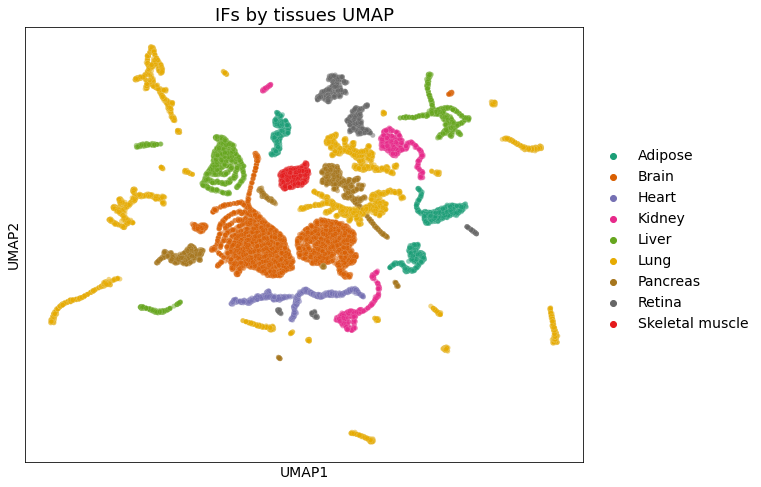

In [39]:
# UMAP for IFs colored by tissues
fig, ax = plt.subplots(figsize=(10,8))
sns.scatterplot(data=df, x='UMAP1', y= 'UMAP2', hue='ORGAN', palette=pal, 
                hue_order=['Adipose', 'Brain', 'Heart', 'Kidney', 'Liver', 'Lung', 'Pancreas', 'Retina', 'Skeletal muscle'],
                s=25, linewidth=0.15, alpha = 0.5)
ax.set_ylabel('UMAP2', fontsize=14)
ax.set_xlabel('UMAP1', fontsize=14)
ax.set_xticks([])
ax.set_xticklabels([])
ax.set_yticks([])
ax.set_yticklabels([])
# Legend
celulas = ['Adipose', 'Brain', 'Heart', 'Kidney', 'Liver', 'Lung', 'Pancreas', 'Retina', 'Skeletal muscle']
h, l = ax.get_legend_handles_labels()
legend= ax.legend(h, celulas, bbox_to_anchor=(1.005, 0.75), title="", fontsize=14)
legend.set_frame_on(False)
plt.title('IFs by tissues UMAP', size=18)

plt.savefig(outputdir+'/IF_umap.png',bbox_inches='tight', dpi=600)
plt.show()

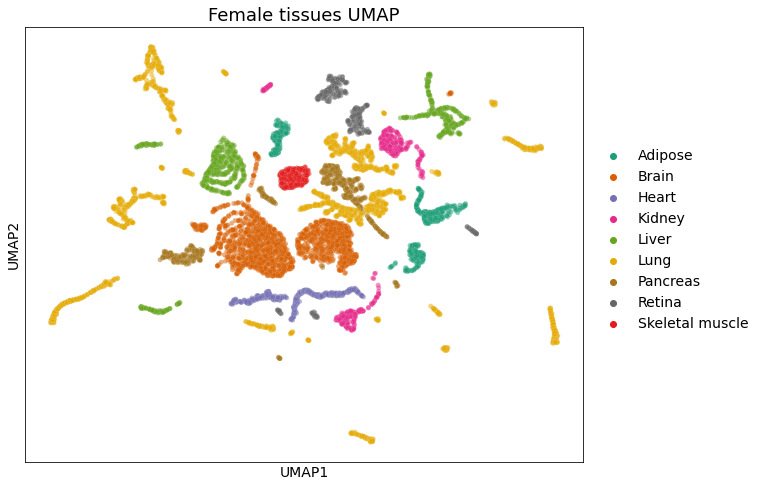

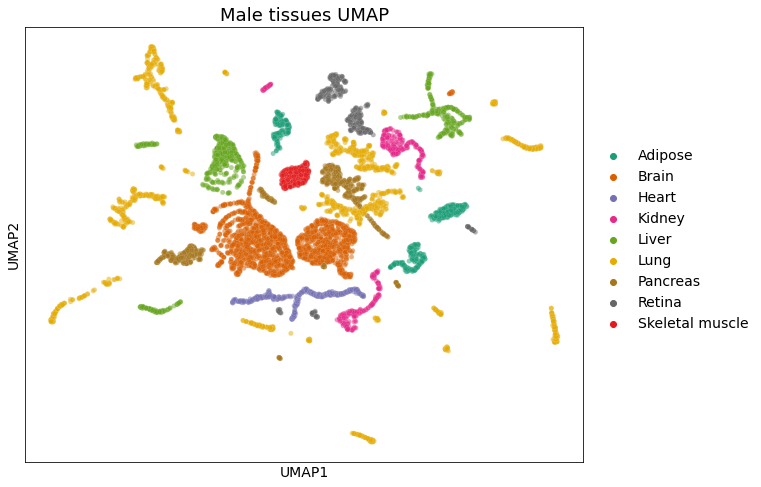

In [40]:
# UMAPs for IFs per gender colored by tissues
for i in df.SEX.unique():    
    fig, ax = plt.subplots(figsize=(10,8))
    sns.scatterplot(data=df[df['SEX']==i], x='UMAP1', y= 'UMAP2', 
                    hue='ORGAN', palette=pal, 
                    hue_order=['Adipose', 'Brain', 'Heart', 'Kidney', 'Liver', 
                               'Lung', 'Pancreas', 'Retina', 'Skeletal muscle'],
                    s=25, linewidth=0.15, alpha = 0.5)
    ax.set_ylabel('UMAP2', fontsize=14)
    ax.set_xlabel('UMAP1', fontsize=14)
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_yticklabels([])
    # Legend
    celulas = ['Adipose', 'Brain', 'Heart', 'Kidney', 'Liver', 'Lung', 'Pancreas', 'Retina', 'Skeletal muscle']
    h, l = ax.get_legend_handles_labels()
    legend= ax.legend(h, celulas, bbox_to_anchor=(1.005, 0.75), title="", fontsize=14)
    legend.set_frame_on(False)
    plt.title('{} tissues UMAP'.format(i), size=18)

    if i == 'Female':
        plt.savefig(outputdir+'/IF_umap_f.png',bbox_inches='tight', dpi=600)
    else:
        plt.savefig(outputdir+'/IF_umap_m.png',bbox_inches='tight', dpi=600)

    plt.show()

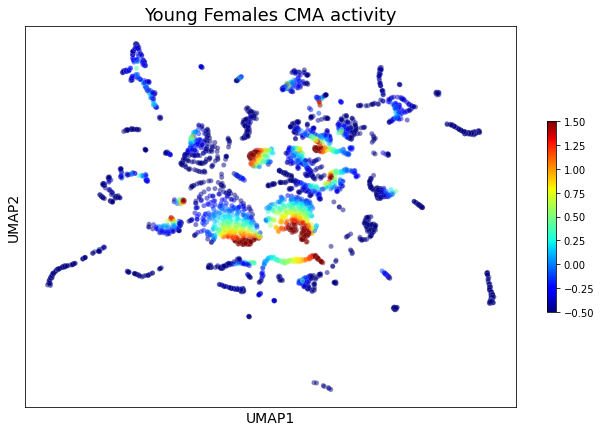

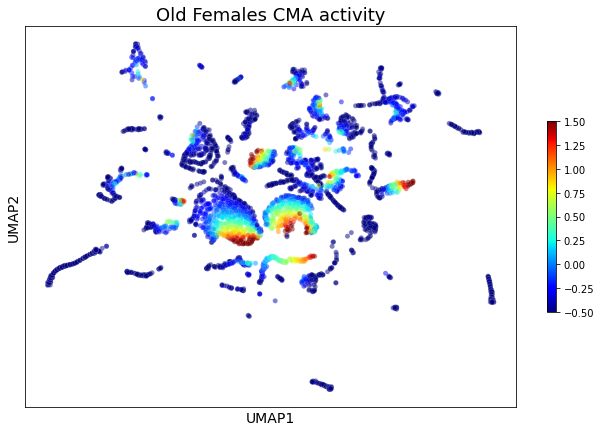

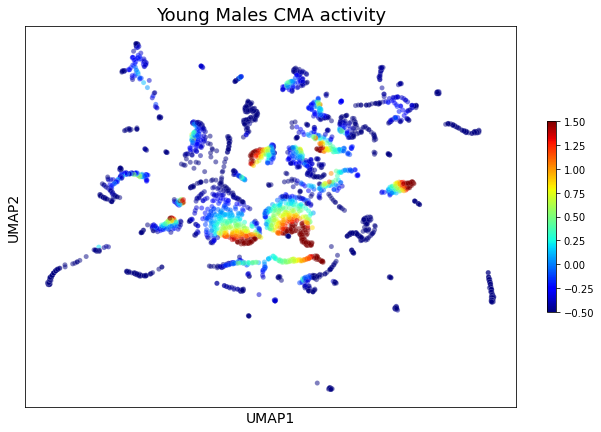

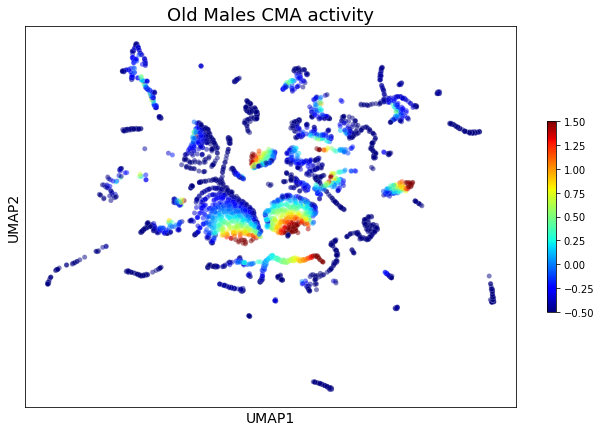

In [49]:
#UMAPs for IFs CMA activity per gender & age
for i in df.SEX.unique():
    for j in df.AGE.unique():
        fig, ax = plt.subplots(figsize=(11,7))
        scatter= sns.scatterplot(data=df[(df['SEX']==i)&(df['AGE']==j)], 
                                 x='UMAP1', y= 'UMAP2', 
                                 c=df[(df['SEX']==i)&(df['AGE']==j)]['std_CMA_actv'], 
                                 cmap='jet', s=25, linewidth=0.15, 
                                 alpha = 0.5, vmin=-0.5, vmax=1.5) 
        norm = plt.Normalize(-0.5, 1.5)
        sm = plt.cm.ScalarMappable(cmap="jet", norm=norm)
        sm.set_array([])
        ax.figure.colorbar(sm, shrink=.5)
        ax.set_ylabel('UMAP2', fontsize=14)
        ax.set_xlabel('UMAP1', fontsize=14)
        ax.set_xticks([])
        ax.set_xticklabels([])
        ax.set_yticks([])
        ax.set_yticklabels([])
        plt.title('{} {}s CMA activity'.format(j, i), size=18)    

        if i == 'Female' and j == 'Young':
            plt.savefig(outputdir+'/IF_umap_'+'fycma.png',bbox_inches='tight', 
                        dpi=600)
        elif i == 'Female' and j == 'Old':
           plt.savefig(outputdir+'/IF_umap_'+'focma.png',bbox_inches='tight', 
                        dpi=600)
        elif i == 'Male' and j == 'Young':
            plt.savefig(outputdir+'/IF_umap_'+'mycma.png',bbox_inches='tight', 
                        dpi=600)
        else:
            plt.savefig(outputdir+'/IF_umap_'+'mocma.png',bbox_inches='tight', 
                        dpi=600)
        plt.show()

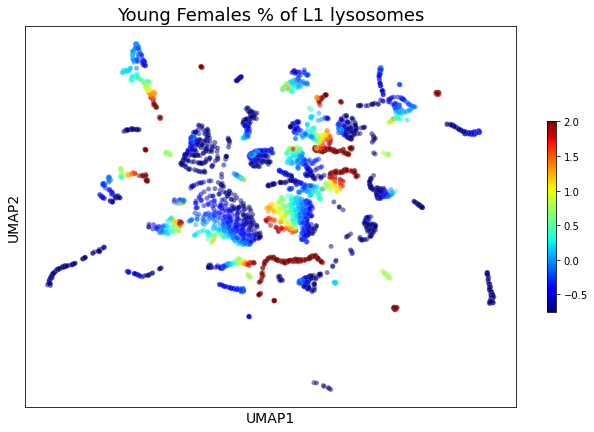

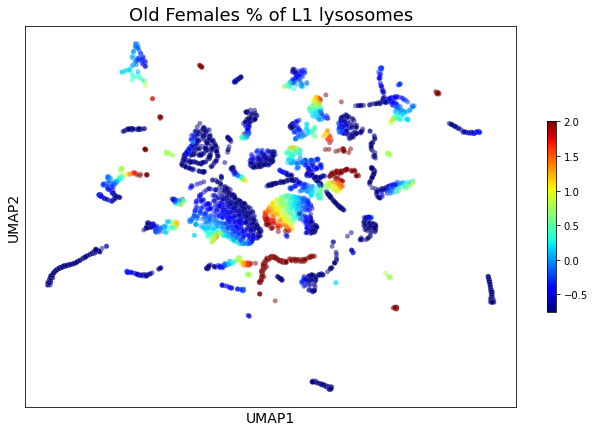

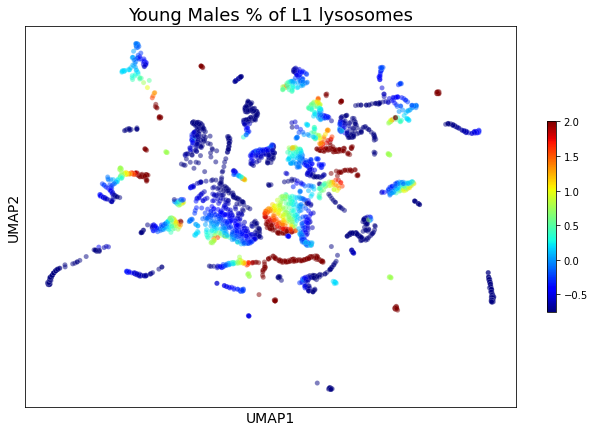

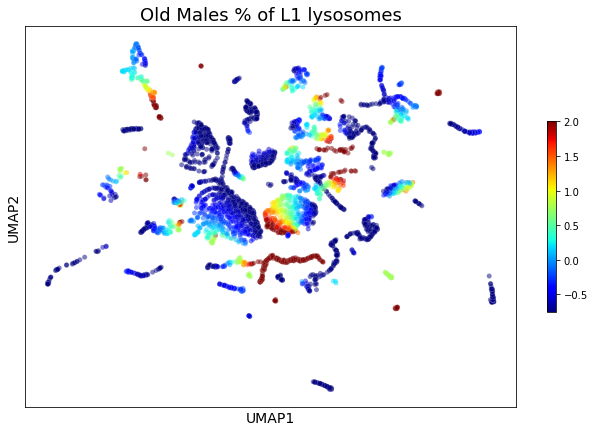

In [55]:
#UMAPs for IFs % of L1 per gender & age
for i in df.SEX.unique():
    for j in df.AGE.unique():
        fig, ax = plt.subplots(figsize=(11,7))
        scatter= sns.scatterplot(data=df[(df['SEX']==i)&(df['AGE']==j)], 
                                 x='UMAP1', y= 'UMAP2', 
                                 c=df[(df['SEX']==i)&(df['AGE']==j)]['std_%L1'], 
                                 cmap='jet', s=25, linewidth=0.15, 
                                 alpha = 0.5, vmin=-0.75, vmax= 2) 
        norm = plt.Normalize(-0.75, 2)
        sm = plt.cm.ScalarMappable(cmap="jet", norm=norm)
        sm.set_array([])
        ax.figure.colorbar(sm, shrink=.5)
        ax.set_ylabel('UMAP2', fontsize=14)
        ax.set_xlabel('UMAP1', fontsize=14)
        ax.set_xticks([])
        ax.set_xticklabels([])
        ax.set_yticks([])
        ax.set_yticklabels([])
        plt.title('{} {}s % of L1 lysosomes'.format(j, i), size=18)    
        if i == 'Female' and j == 'Young':
            plt.savefig(outputdir+'/IF_umap_'+'fyl1per.png',bbox_inches='tight', 
                        dpi=600)
        elif i == 'Female' and j == 'Old':
            plt.savefig(outputdir+'/IF_umap_'+'fol1per.png',bbox_inches='tight', 
                        dpi=600)
        elif i == 'Male' and j == 'Young':
            plt.savefig(outputdir+'/IF_umap_'+'myl1per.png',bbox_inches='tight', 
                        dpi=600)
        else:
            plt.savefig(outputdir+'/IF_umap_'+'mol1per.png',bbox_inches='tight', 
                        dpi=600)
        plt.show()
    

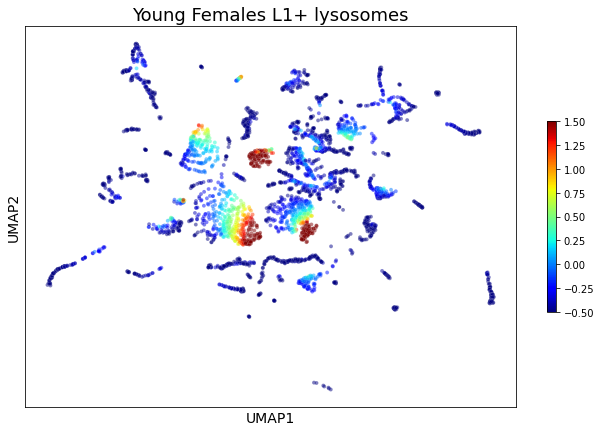

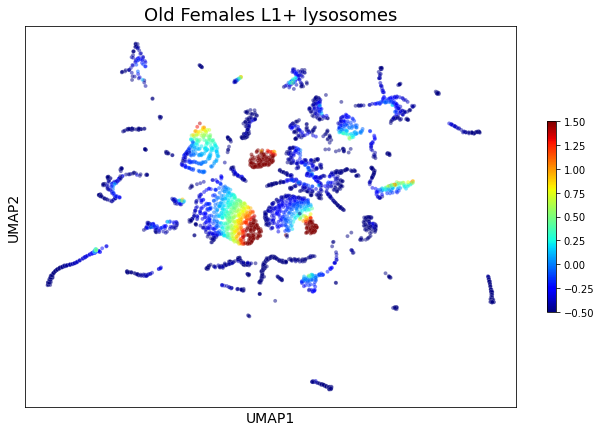

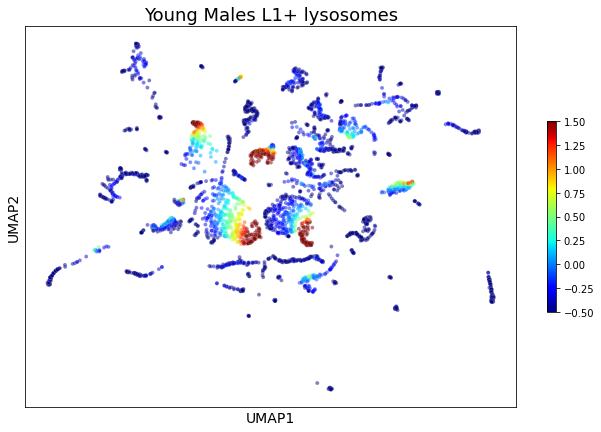

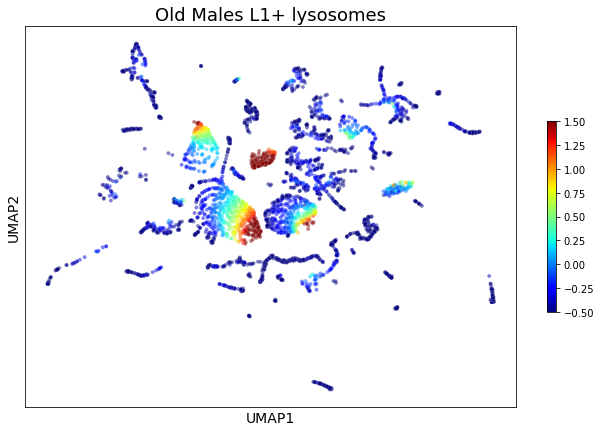

In [61]:
#UMAPs for IFs L1 positive per gender & age
for i in df.SEX.unique():
    for j in df.AGE.unique():
        fig, ax = plt.subplots(figsize=(11,7))
        scatter= sns.scatterplot(data=df[(df['SEX']==i)&(df['AGE']==j)], 
                                 x='UMAP1', y= 'UMAP2', 
                                 c=df[(df['SEX']==i)&(df['AGE']==j)]['std_L1+'], 
                                 cmap='jet', s=15, linewidth=0.15, 
                                 alpha = 0.5, vmin=-0.5, vmax=1.5) 
        norm = plt.Normalize(-0.5, 1.5)
        sm = plt.cm.ScalarMappable(cmap="jet", norm=norm)
        sm.set_array([])
        ax.figure.colorbar(sm, shrink=.5)
        ax.set_ylabel('UMAP2', fontsize=14)
        ax.set_xlabel('UMAP1', fontsize=14)
        ax.set_xticks([])
        ax.set_xticklabels([])
        ax.set_yticks([])
        ax.set_yticklabels([])
        plt.title('{} {}s L1+ lysosomes'.format(j, i), size=18)    

        if i == 'Female' and j == 'Young':
            plt.savefig(outputdir+'/IF_umap_'+'fyl1pos.png',bbox_inches='tight', 
                        dpi=600)
        elif i == 'Female' and j == 'Old':
            plt.savefig(outputdir+'/IF_umap_'+'fol1pos.png',bbox_inches='tight', 
                        dpi=600)
        elif i == 'Male' and j == 'Young':
            plt.savefig(outputdir+'/IF_umap_'+'myl1pos.png',bbox_inches='tight', 
                        dpi=600)
        else:
            plt.savefig(outputdir+'/IF_umap_'+'mol1pos.png',bbox_inches='tight', 
                        dpi=600)
        plt.show()

C:\Users\Adrian\AppData\Local\Temp\ipykernel_6068\2768663139.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=[-0.50, -0.25, 0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5], size=14)


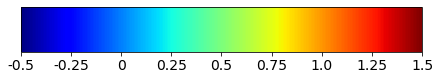

In [85]:
# Colorbars independently. First for CMA activity
fig, ax = plt.subplots(figsize=(6, 1), layout='constrained')

cmap = mpl.cm.jet
norm = mpl.colors.Normalize(vmin=-0.5, vmax=1.5)

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=ax, orientation='horizontal')

ax.set_xticklabels(labels=[-0.50, -0.25, 0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5], size=14)
plt.savefig(outputdir+'/cbar_cmaact.png',bbox_inches='tight', dpi=600)
plt.show()

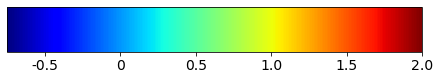

In [89]:
# Colorbars independently. Second for %L1
fig, ax = plt.subplots(figsize=(6, 1), layout='constrained')

cmap = mpl.cm.jet
norm = mpl.colors.Normalize(vmin=-0.75, vmax=2)

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=ax, orientation='horizontal')

ax.set_xticks([-0.50, 0, 0.5, 1.0, 1.5, 2.0])
ax.set_xticklabels(labels=[-0.50, 0, 0.5, 1.0, 1.5, 2.0], size=14)
plt.savefig(outputdir+'/cbar_l1per.png',bbox_inches='tight', dpi=600)
plt.show()

C:\Users\Adrian\AppData\Local\Temp\ipykernel_6068\3629892395.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=[-0.50, -0.25, 0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5], size=14)


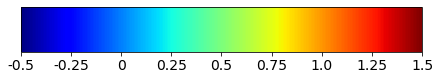

In [90]:
# Colorbars independently. Third for L1 positive
fig, ax = plt.subplots(figsize=(6, 1), layout='constrained')

cmap = mpl.cm.jet
norm = mpl.colors.Normalize(vmin=-0.5, vmax=1.5)

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=ax, orientation='horizontal')

ax.set_xticklabels(labels=[-0.50, -0.25, 0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5], size=14)
plt.savefig(outputdir+'/cbar_l1pos.png',bbox_inches='tight', dpi=600)
plt.show()

## 3. Summary plots all cell types and all lysosomal parameters

In [3]:
df = pd.read_excel('./CMA_aging_Atlas_sumdata.xlsx')
df.head()

Cell_type    Gender_Age  CMA activity  CMA score  \
0                Acinar Cells    Female Old       -0.6092    -1.0381   
1                Acinar Cells  Female Young        0.4535     0.2207   
2                Acinar Cells      Male Old       -1.0201    -0.4687   
3                Acinar Cells    Male Young        1.1758     1.2861   
4  Alveolar Epithelial Type I    Female Old       -1.1247    -1.4114   

   Fraction CMA Lys  L1 number  
0           -0.8959     0.1566  
1            1.1509    -0.0115  
2           -0.7757    -1.2901  
3            0.5207     1.1450  
4           -1.0761     1.4667

In [4]:
df.Cell_type.unique()

array(['Acinar Cells', 'Alveolar Epithelial Type I',
       'Alveolar Epithelial Type II', 'BAT', 'CA1 astrocytes',
       'CA1 neurons', 'CB excitatory neurons', 'CB inhibitory neurons',
       'Cardiomyocytes', 'Collecting Ducts', 'Cone photoreceptors',
       'DG astrocytes', 'DG neurons', 'EC astrocytes', 'EC neurons',
       'Glomeruli', 'Hepatocytes', 'Kupffer Cells',
       'Lung Endothelial Cells', 'Lung Fibroblasts',
       'Rods photoreceptors', 'SC astrocytes', 'SC neurons',
       'Skeletal Myofibers', 'Tubules', 'sWAT', 'vWAT', 'α-Cells',
       'β-Cells'], dtype=object)

In [6]:
celulas = ['CA1 neurons', 'DG neurons', 'SC neurons', 'EC neurons',
           'CA1 astrocytes', 'DG astrocytes', 'SC astrocytes', 'EC astrocytes', 
           'CB inhibitory neurons', 'CB excitatory neurons',  
           'Rods photoreceptors', 'Cone photoreceptors', 'Hepatocytes', 
           'Kupffer Cells', 'BAT', 'vWAT', 'sWAT', 'Acinar Cells', 'β-Cells',
           'α-Cells', 'Skeletal Myofibers', 'Alveolar Epithelial Type I', 
           'Alveolar Epithelial Type II', 'Lung Fibroblasts', 
           'Lung Endothelial Cells', 'Glomeruli', 'Tubules', 
           'Collecting Ducts', 'Cardiomyocytes']

#Cell names without retina cells because they are not in Tabula muris
celulas2 = ['CA1 neurons', 'DG neurons', 'SC neurons', 'EC neurons',
           'CA1 astrocytes', 'DG astrocytes', 'SC astrocytes', 'EC astrocytes', 
           'CB inhibitory neurons', 'CB excitatory neurons', 'Hepatocytes', 
           'Kupffer Cells', 'BAT', 'vWAT', 'sWAT', 'Acinar Cells', 'β-Cells',
           'α-Cells', 'Skeletal Myofibers', 'Alveolar Epithelial Type I', 
           'Alveolar Epithelial Type II', 'Lung Fibroblasts', 
           'Lung Endothelial Cells', 'Glomeruli', 'Tubules', 
           'Collecting Ducts', 'Cardiomyocytes']

#Brain cells' names
brain = ['CA1 neurons', 'DG neurons', 'SC neurons', 'EC neurons',
         'CA1 astrocytes', 'DG astrocytes', 'SC astrocytes', 'EC astrocytes', 
         'CB inhibitory neurons', 'CB excitatory neurons',  
         'Rods photoreceptors', 'Cone photoreceptors']

#Brain cells' names no retina
brain2 = ['CA1 neurons', 'DG neurons', 'SC neurons', 'EC neurons',
          'CA1 astrocytes', 'DG astrocytes', 'SC astrocytes', 'EC astrocytes', 
          'CB inhibitory neurons', 'CB excitatory neurons']

#Metabolic cells' names
metab = ['Hepatocytes', 'Kupffer Cells', 'BAT', 'vWAT', 'sWAT', 'Acinar Cells', 'β-Cells',
         'α-Cells', 'Skeletal Myofibers']

In [12]:
#Cell names without lung and heart
celulas3 = ['CA1 neurons', 'DG neurons', 'SC neurons', 'EC neurons',
           'CA1 astrocytes', 'DG astrocytes', 'SC astrocytes', 'EC astrocytes', 
           'CB inhibitory neurons', 'CB excitatory neurons',  
           'Rods photoreceptors', 'Cone photoreceptors', 'Hepatocytes', 
           'Kupffer Cells', 'BAT', 'vWAT', 'sWAT', 'Acinar Cells', 'β-Cells',
           'α-Cells', 'Skeletal Myofibers', 'Glomeruli', 'Tubules', 
           'Collecting Ducts']

celulas4 = ['CA1 neurons', 'DG neurons', 'SC neurons', 'EC neurons',
           'CA1 astrocytes', 'DG astrocytes', 'SC astrocytes', 'EC astrocytes', 
           'CB inhibitory neurons', 'CB excitatory neurons',  
           'Hepatocytes', 'Kupffer Cells', 'BAT', 'vWAT', 'sWAT', 'Acinar Cells', 'β-Cells',
           'α-Cells', 'Skeletal Myofibers', 'Glomeruli', 'Tubules', 
           'Collecting Ducts']

In [8]:
#Df with no retina cells
df2 = df.loc[df['Cell_type'].isin(celulas2), :]
df2.shape

(108, 6)

In [9]:
#Setting Gender & age cathegories
df['Gender_Age']=pd.Categorical(values=df.Gender_Age, categories=['Female Young', 'Female Old', 'Male Young', 'Male Old'], ordered=True)
df2['Gender_Age']=pd.Categorical(values=df2.Gender_Age, categories=['Female Young', 'Female Old', 'Male Young', 'Male Old'], ordered=True)

C:\Users\Adrian\AppData\Local\Temp\ipykernel_4940\2668924074.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Gender_Age']=pd.Categorical(values=df2.Gender_Age, categories=['Female Young', 'Female Old', 'Male Young', 'Male Old'], ordered=True)


In [10]:
#Setting cell type cathegories
df['Cell_type']=pd.Categorical(values=df.Cell_type, categories=celulas, ordered=True)
df2['Cell_type']=pd.Categorical(values=df2.Cell_type, categories=celulas2, ordered=True)

C:\Users\Adrian\AppData\Local\Temp\ipykernel_4940\4148413832.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Cell_type']=pd.Categorical(values=df2.Cell_type, categories=celulas2, ordered=True)


/tmp/ipykernel_15489/2146613591.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Y', 'O', 'Y', 'O'], size= 14)


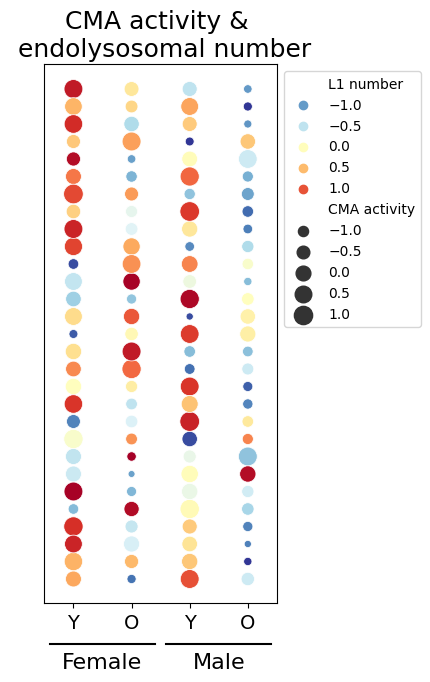

/tmp/ipykernel_15489/2146613591.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Y', 'O', 'Y', 'O'], size= 14)
/tmp/ipykernel_15489/2146613591.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(celulas, size= 14)


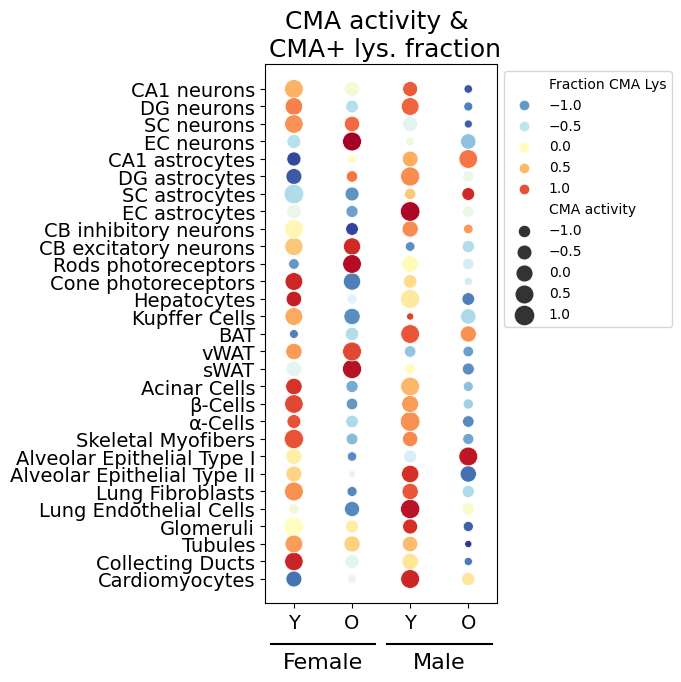

In [96]:
#Summary graphs combining parameters
for i in ['L1 number', 'Fraction CMA Lys']:
    fig, ax = plt.subplots(figsize=(3,7))
    sns.scatterplot(data=df, x='Gender_Age', y='Cell_type', size='CMA activity', 
                    hue=i, palette='RdYlBu_r', sizes=(25, 200))
    plt.legend(bbox_to_anchor=(1, 1))
    plt.xlabel('')
    plt.ylabel('')
    plt.xlim(-0.5, 3.5)
    ax.set_xticklabels(['Y', 'O', 'Y', 'O'], size= 14)

    if i == 'L1 number':
        ax.set_yticklabels([])
        ax.set_yticks([])
    else:
        ax.set_yticklabels(celulas, size= 14)
        

    # Female & male
    trans = ax.get_xaxis_transform()
    ax.annotate('Female', xy=(0.5, -0.09), xycoords=trans, ha="center", va="top", size=16)
    ax.plot([-.4,1.4],[-.075,-.075], color="k", transform=trans, clip_on=False)
    ax.annotate('Male', xy=(2.5, -0.09), xycoords=trans, ha="center", va="top", size=16)
    ax.plot([1.6,3.4],[-.075,-.075], color="k", transform=trans, clip_on=False)


    if i == 'L1 number':
        plt.title('CMA activity & \n endolysosomal number', size=18)        
        plt.savefig(outputdir+'/Sum_cmal1pos.png',bbox_inches='tight', dpi=600)
    else:
        plt.title('CMA activity & \n CMA+ lys. fraction', size=18)
        plt.savefig(outputdir+'/Sum_cmal1per.png',bbox_inches='tight', dpi=600)
    plt.show()

/tmp/ipykernel_15489/509680383.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(celulas2, size= 14)
/tmp/ipykernel_15489/509680383.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Y', 'O', 'Y', 'O'], size= 14)


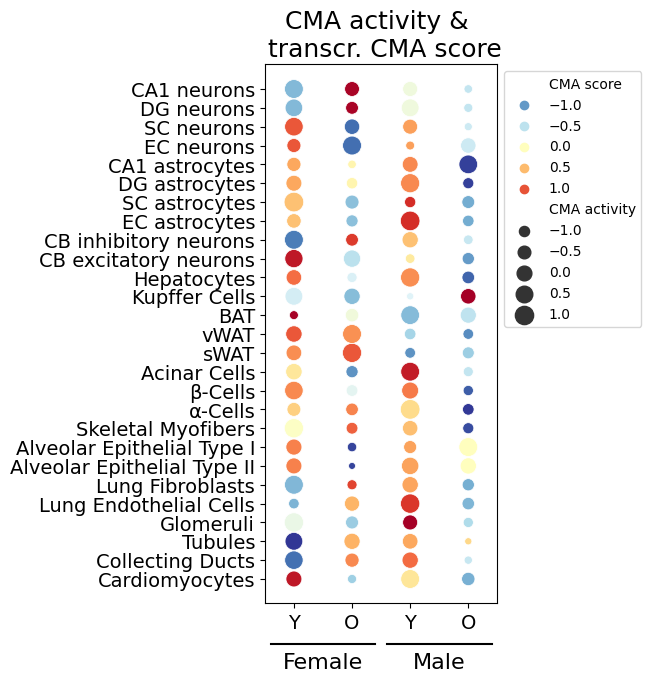

In [97]:
#Summary graph for CMA activity and score, separated because we don´t have CMA score for retina cells
fig, ax = plt.subplots(figsize=(3,7))
sns.scatterplot(data=df2, x='Gender_Age', y='Cell_type', size='CMA activity', 
                hue='CMA score', palette='RdYlBu_r', sizes=(25, 200))
plt.legend(bbox_to_anchor=(1, 1))
plt.xlabel('')
plt.ylabel('')
plt.xlim(-0.5, 3.5)
ax.set_yticklabels(celulas2, size= 14)
ax.set_xticklabels(['Y', 'O', 'Y', 'O'], size= 14)

# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0.5, -0.09), xycoords=trans, ha="center", va="top", size=16)
ax.plot([-.4,1.4],[-.075,-.075], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(2.5, -0.09), xycoords=trans, ha="center", va="top", size=16)
ax.plot([1.6,3.4],[-.075,-.075], color="k", transform=trans, clip_on=False)

plt.title('CMA activity & \n transcr. CMA score', size=18)
plt.savefig(outputdir+'/Sum_actsco.png',bbox_inches='tight', dpi=600)
plt.show()

/tmp/ipykernel_15489/509680383.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(celulas2, size= 14)
/tmp/ipykernel_15489/509680383.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Y', 'O', 'Y', 'O'], size= 14)


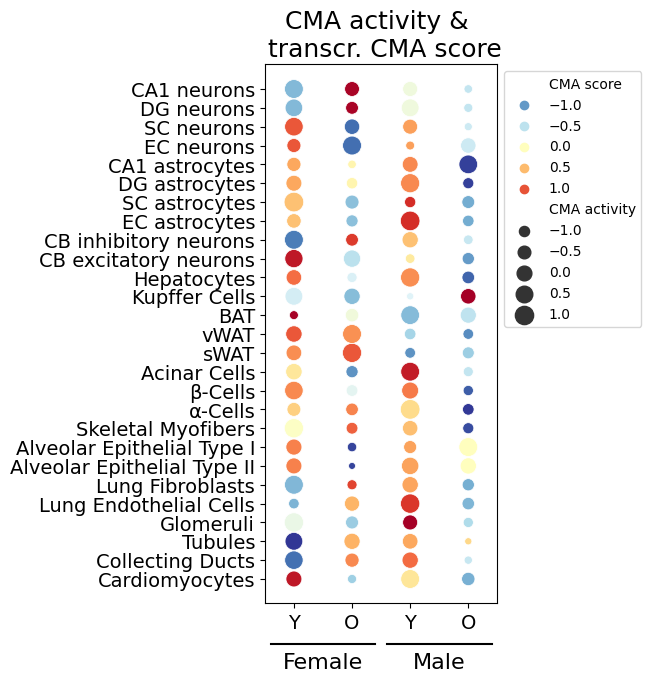

In [ ]:
#Summary graph for CMA activity and score, separated because we don´t have CMA score for retina cells
fig, ax = plt.subplots(figsize=(3,7))
sns.scatterplot(data=df2, x='Gender_Age', y='Cell_type', size='CMA activity', 
                hue='CMA score', palette='RdYlBu_r', sizes=(25, 200))
plt.legend(bbox_to_anchor=(1, 1))
plt.xlabel('')
plt.ylabel('')
plt.xlim(-0.5, 3.5)
ax.set_yticklabels(celulas2, size= 14)
ax.set_xticklabels(['Y', 'O', 'Y', 'O'], size= 14)

# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0.5, -0.09), xycoords=trans, ha="center", va="top", size=16)
ax.plot([-.4,1.4],[-.075,-.075], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(2.5, -0.09), xycoords=trans, ha="center", va="top", size=16)
ax.plot([1.6,3.4],[-.075,-.075], color="k", transform=trans, clip_on=False)

plt.title('CMA activity & \n transcr. CMA score', size=18)
plt.savefig(outputdir+'/Sum_actsco.png',bbox_inches='tight', dpi=600)
plt.show()

In [22]:
subset_df = df[df['Cell_type'].isin(celulas3)]
subset_df2 = df[df['Cell_type'].isin(celulas4)]

#Setting cell type cathegories
subset_df['Cell_type']=pd.Categorical(values=subset_df.Cell_type, categories=celulas3, ordered=True)
subset_df2['Cell_type']=pd.Categorical(values=subset_df2.Cell_type, categories=celulas4, ordered=True)

C:\Users\Adrian\AppData\Local\Temp\ipykernel_4940\4144236565.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df['Cell_type']=pd.Categorical(values=subset_df.Cell_type, categories=celulas3, ordered=True)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_4940\4144236565.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df2['Cell_type']=pd.Categorical(values=subset_df2.Cell_type, categories=celulas4, ordered=True)


In [3]:
outputdir = r'C:\Users\Adrian\OneDrive - FUNDACION IMDEA-ALIMENTACION\Cuervo_lab\Dendra_paper\Final_figs_v2'

In [24]:
categories = subset_df['Cell_type'].cat.categories
print(categories)

Index(['CA1 neurons', 'DG neurons', 'SC neurons', 'EC neurons',
       'CA1 astrocytes', 'DG astrocytes', 'SC astrocytes', 'EC astrocytes',
       'CB inhibitory neurons', 'CB excitatory neurons', 'Rods photoreceptors',
       'Cone photoreceptors', 'Hepatocytes', 'Kupffer Cells', 'BAT', 'vWAT',
       'sWAT', 'Acinar Cells', 'β-Cells', 'α-Cells', 'Skeletal Myofibers',
       'Glomeruli', 'Tubules', 'Collecting Ducts'],
      dtype='object')


C:\Users\Adrian\AppData\Local\Temp\ipykernel_4940\835490517.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Y', 'O', 'Y', 'O'], size= 14)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_4940\835490517.py:14: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_yticks([])
C:\Users\Adrian\AppData\Local\Temp\ipykernel_4940\835490517.py:29: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.savefig(outputdir+'\Sum_cmal1pos_trial.png',bbox_inches='tight', dpi=600)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_4940\835490517.py:29: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support wi

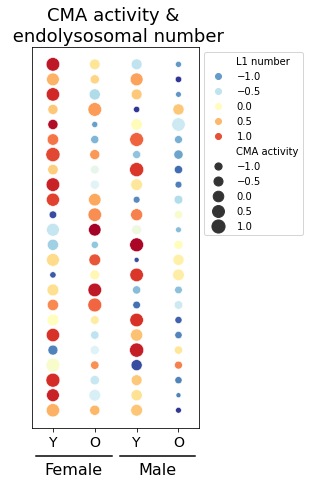

C:\Users\Adrian\AppData\Local\Temp\ipykernel_4940\835490517.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Y', 'O', 'Y', 'O'], size= 14)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_4940\835490517.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(celulas3, size= 14)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_4940\835490517.py:32: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.savefig(outputdir+'\Sum_cmal1per_trial2.png',bbox_inches='tight', dpi=600)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_4940\835490517.py:32: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.savefig(outputdir

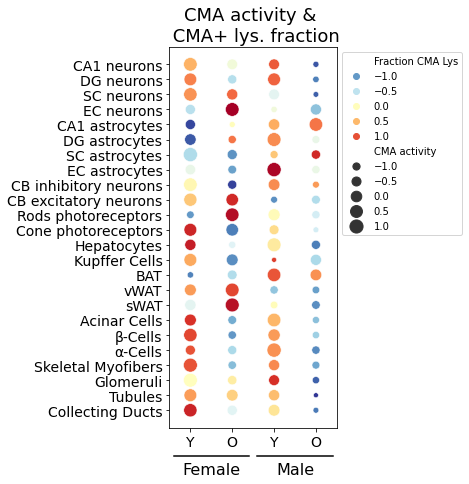

In [28]:
#Summary graphs combining parameters
for i in ['L1 number', 'Fraction CMA Lys']:
    fig, ax = plt.subplots(figsize=(3,7))
    sns.scatterplot(data=subset_df, x='Gender_Age', y='Cell_type', size='CMA activity', 
                    hue=i, palette='RdYlBu_r', sizes=(25, 200))
    plt.legend(bbox_to_anchor=(1, 1))
    plt.xlabel('')
    plt.ylabel('')
    plt.xlim(-0.5, 3.5)
    ax.set_xticklabels(['Y', 'O', 'Y', 'O'], size= 14)

    if i == 'L1 number':
        ax.set_yticklabels([])
        ax.set_yticks([])
    else:
        ax.set_yticklabels(celulas3, size= 14)
        

    # Female & male
    trans = ax.get_xaxis_transform()
    ax.annotate('Female', xy=(0.5, -0.09), xycoords=trans, ha="center", va="top", size=16)
    ax.plot([-.4,1.4],[-.075,-.075], color="k", transform=trans, clip_on=False)
    ax.annotate('Male', xy=(2.5, -0.09), xycoords=trans, ha="center", va="top", size=16)
    ax.plot([1.6,3.4],[-.075,-.075], color="k", transform=trans, clip_on=False)


    if i == 'L1 number':
        plt.title('CMA activity & \n endolysosomal number', size=18)        
        plt.savefig(outputdir+'\Sum_cmal1pos_trial.png',bbox_inches='tight', dpi=600)
    else:
        plt.title('CMA activity & \n CMA+ lys. fraction', size=18)
        plt.savefig(outputdir+'\Sum_cmal1per_trial2.png',bbox_inches='tight', dpi=600)
    plt.show()

C:\Users\Adrian\AppData\Local\Temp\ipykernel_4940\2539427104.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(celulas4, size= 14)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_4940\2539427104.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Y', 'O', 'Y', 'O'], size= 14)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_4940\2539427104.py:20: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.savefig(outputdir+'/Sum_actsco_trial3.png',bbox_inches='tight', dpi=600)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_4940\2539427104.py:20: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.savefig(outputdi

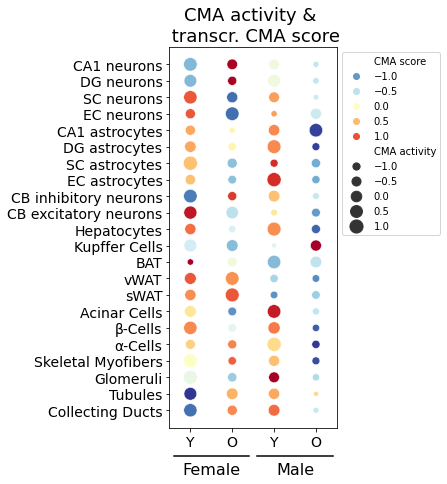

In [30]:
#Summary graph for CMA activity and score, separated because we don´t have CMA score for retina cells
fig, ax = plt.subplots(figsize=(3,7))
sns.scatterplot(data=subset_df2, x='Gender_Age', y='Cell_type', size='CMA activity', 
                hue='CMA score', palette='RdYlBu_r', sizes=(25, 200))
plt.legend(bbox_to_anchor=(1, 1))
plt.xlabel('')
plt.ylabel('')
plt.xlim(-0.5, 3.5)
ax.set_yticklabels(celulas4, size= 14)
ax.set_xticklabels(['Y', 'O', 'Y', 'O'], size= 14)

# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0.5, -0.09), xycoords=trans, ha="center", va="top", size=16)
ax.plot([-.4,1.4],[-.075,-.075], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(2.5, -0.09), xycoords=trans, ha="center", va="top", size=16)
ax.plot([1.6,3.4],[-.075,-.075], color="k", transform=trans, clip_on=False)

plt.title('CMA activity & \n transcr. CMA score', size=18)
plt.savefig(outputdir+'/Sum_actsco_trial3.png',bbox_inches='tight', dpi=600)
plt.show()

## Creating subsets for graphs of CNS and Metabolic tissues alone

In [31]:
brain_df = df[df['Cell_type'].isin(brain)]
brain_df2 = df[df['Cell_type'].isin(brain2)]
metab_df = df[df['Cell_type'].isin(metab)]


#Setting cell type cathegories
brain_df['Cell_type']=pd.Categorical(values=brain_df.Cell_type, categories=brain, ordered=True)
brain_df2['Cell_type']=pd.Categorical(values=brain_df2.Cell_type, categories=brain2, ordered=True)
metab_df['Cell_type']=pd.Categorical(values=metab_df.Cell_type, categories=metab, ordered=True)


C:\Users\Adrian\AppData\Local\Temp\ipykernel_4940\2995826665.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  brain_df['Cell_type']=pd.Categorical(values=brain_df.Cell_type, categories=brain, ordered=True)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_4940\2995826665.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  brain_df2['Cell_type']=pd.Categorical(values=brain_df2.Cell_type, categories=brain2, ordered=True)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_4940\2995826665.py:9: SettingWithCopyWarning: 

<>:3: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:3: SyntaxWarning: "is not" with a literal. Did you mean "!="?
C:\Users\Adrian\AppData\Local\Temp\ipykernel_4940\2044770627.py:3: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if i is not 'CMA score':
C:\Users\Adrian\AppData\Local\Temp\ipykernel_4940\2044770627.py:12: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\Adrian\AppData\Local\Temp\ipykernel_4940\2044770627.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(brain, size= 14)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_4940\2044770627.py:17: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units inste

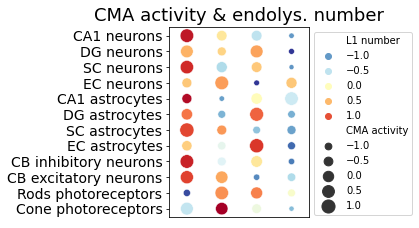

C:\Users\Adrian\AppData\Local\Temp\ipykernel_4940\2044770627.py:12: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\Adrian\AppData\Local\Temp\ipykernel_4940\2044770627.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(brain, size= 14)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_4940\2044770627.py:20: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.savefig(outputdir+'\Sum_cmal1per_cns.png',bbox_inches='tight', dpi=600)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_4940\2044770627.py:20: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed

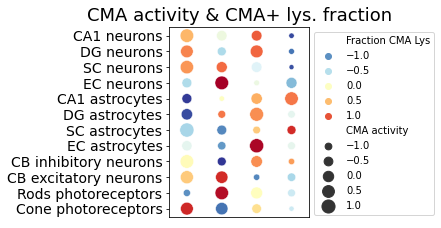

C:\Users\Adrian\AppData\Local\Temp\ipykernel_4940\2044770627.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Y', 'O', 'Y', 'O'], size= 14)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_4940\2044770627.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(brain2, size= 14)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_4940\2044770627.py:41: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.savefig(outputdir+'\Sum_actsco_cns.png',bbox_inches='tight', dpi=600)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_4940\2044770627.py:41: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.savefig(outputdir+'\

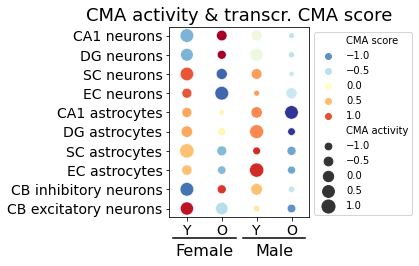

In [38]:
#Summary graphs for CNS only
for i in ['L1 number', 'Fraction CMA Lys', 'CMA score']:
    if i is not 'CMA score':
        fig, ax = plt.subplots(figsize=(2.5,3.5))
        sns.scatterplot(data=brain_df, x='Gender_Age', y='Cell_type', size='CMA activity', 
                        hue=i, palette='RdYlBu_r', sizes=(25, 200))
        plt.legend(bbox_to_anchor=(1, 1))
        plt.xlabel('')
        plt.ylabel('')
        plt.xlim(-0.5, 3.5)
        ax.set_xticklabels([])
        ax.set_xticks([])
        ax.set_yticklabels(brain, size= 14)

        if i == 'L1 number':
            plt.title('CMA activity & endolys. number', size=18)        
            plt.savefig(outputdir+'\Sum_cmal1pos_cns.png',bbox_inches='tight', dpi=600)
        else:
            plt.title('CMA activity & CMA+ lys. fraction', size=18)
            plt.savefig(outputdir+'\Sum_cmal1per_cns.png',bbox_inches='tight', dpi=600)

    else:
        fig, ax = plt.subplots(figsize=(2.5, 3.5))
        sns.scatterplot(data=brain_df2, x='Gender_Age', y='Cell_type', size='CMA activity', 
                        hue=i, palette='RdYlBu_r', sizes=(25, 200))
        plt.legend(bbox_to_anchor=(1, 1))
        plt.xlabel('')
        plt.ylabel('')
        plt.xlim(-0.5, 3.5)
        ax.set_xticklabels(['Y', 'O', 'Y', 'O'], size= 14)
        ax.set_yticklabels(brain2, size= 14)
        
        # Female & male
        trans = ax.get_xaxis_transform()
        ax.annotate('Female', xy=(0.5, -0.14), xycoords=trans, ha="center", va="top", size=16)
        ax.plot([-.4,1.4],[-.11,-.11], color="k", transform=trans, clip_on=False)
        ax.annotate('Male', xy=(2.5, -0.14), xycoords=trans, ha="center", va="top", size=16)
        ax.plot([1.6,3.4],[-.11,-.11], color="k", transform=trans, clip_on=False)

        plt.title('CMA activity & transcr. CMA score', size=18)
        plt.savefig(outputdir+'\Sum_actsco_cns.png',bbox_inches='tight', dpi=600)
   
    plt.show()

<>:3: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:3: SyntaxWarning: "is not" with a literal. Did you mean "!="?
C:\Users\Adrian\AppData\Local\Temp\ipykernel_4940\3014898421.py:3: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if i is not 'CMA score':
C:\Users\Adrian\AppData\Local\Temp\ipykernel_4940\3014898421.py:12: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\Adrian\AppData\Local\Temp\ipykernel_4940\3014898421.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(metab, size= 14)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_4940\3014898421.py:17: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units inste

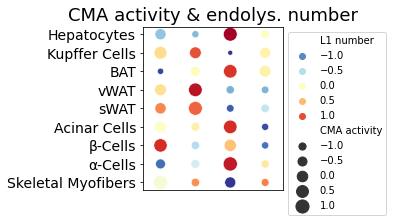

C:\Users\Adrian\AppData\Local\Temp\ipykernel_4940\3014898421.py:12: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\Adrian\AppData\Local\Temp\ipykernel_4940\3014898421.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(metab, size= 14)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_4940\3014898421.py:20: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.savefig(outputdir+'\Sum_cmal1per_metab.png',bbox_inches='tight', dpi=600)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_4940\3014898421.py:20: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be remov

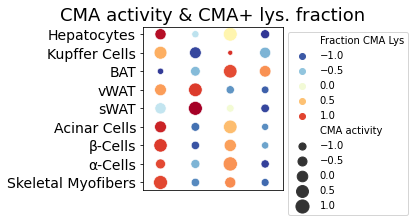

C:\Users\Adrian\AppData\Local\Temp\ipykernel_4940\3014898421.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Y', 'O', 'Y', 'O'], size= 14)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_4940\3014898421.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(metab, size= 14)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_4940\3014898421.py:41: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.savefig(outputdir+'\Sum_actsco_metab.png',bbox_inches='tight', dpi=600)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_4940\3014898421.py:41: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.savefig(outputdir+'

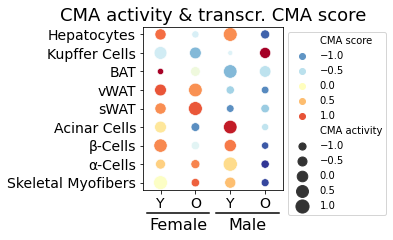

In [41]:
#Summary graphs for Mteabolic tissues only
for i in ['L1 number', 'Fraction CMA Lys', 'CMA score']:
    if i is not 'CMA score':
        fig, ax = plt.subplots(figsize=(2.5,3))
        sns.scatterplot(data=metab_df, x='Gender_Age', y='Cell_type', size='CMA activity', 
                        hue=i, palette='RdYlBu_r', sizes=(25, 200))
        plt.legend(bbox_to_anchor=(1, 1))
        plt.xlabel('')
        plt.ylabel('')
        plt.xlim(-0.5, 3.5)
        ax.set_xticklabels([])
        ax.set_xticks([])
        ax.set_yticklabels(metab, size= 14)

        if i == 'L1 number':
            plt.title('CMA activity & endolys. number', size=18)        
            plt.savefig(outputdir+'\Sum_cmal1pos_metab.png',bbox_inches='tight', dpi=600)
        else:
            plt.title('CMA activity & CMA+ lys. fraction', size=18)
            plt.savefig(outputdir+'\Sum_cmal1per_metab.png',bbox_inches='tight', dpi=600)

    else:
        fig, ax = plt.subplots(figsize=(2.5, 3))
        sns.scatterplot(data=metab_df, x='Gender_Age', y='Cell_type', size='CMA activity', 
                        hue=i, palette='RdYlBu_r', sizes=(25, 200))
        plt.legend(bbox_to_anchor=(1, 1))
        plt.xlabel('')
        plt.ylabel('')
        plt.xlim(-0.5, 3.5)
        ax.set_xticklabels(['Y', 'O', 'Y', 'O'], size= 14)
        ax.set_yticklabels(metab, size= 14)
        
        # Female & male
        trans = ax.get_xaxis_transform()
        ax.annotate('Female', xy=(0.5, -0.17), xycoords=trans, ha="center", va="top", size=16)
        ax.plot([-.4,1.4],[-.14,-.14], color="k", transform=trans, clip_on=False)
        ax.annotate('Male', xy=(2.5, -0.17), xycoords=trans, ha="center", va="top", size=16)
        ax.plot([1.6,3.4],[-.14,-.14], color="k", transform=trans, clip_on=False)

        plt.title('CMA activity & transcr. CMA score', size=18)
        plt.savefig(outputdir+'\Sum_actsco_metab.png',bbox_inches='tight', dpi=600)
   
    plt.show()